# Tumoroscope in PyMC

In this notebook, I reconstruct the 'Tumoroscope' model described by [Shafighi *et al.*](https://www.biorxiv.org/content/10.1101/2022.09.22.508914v1) using the probabilistic programming library [PyMC](https://www.pymc.io/welcome.html).
I build two versions of the model, one as described in the pre-print manuscript, the second with a few simple alterations made easier by not needing to construct a Gibbs Sampling process by hand (additional details are provided in that section of the notebook).

## Setup

In [1]:
import os
from dataclasses import dataclass
from math import ceil
from pathlib import Path
from typing import Any, Final

import aesara.tensor as at
import arviz as az
import janitor  # noqa: F401
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import scipy.stats
import seaborn as sns

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
# Set the default HDI probability to 89%.
az.rcparams.rcParams["stats.hdi_prob"] = 0.89

# Directory for caching posterior distributions.
models_dir = Path("models")
if not models_dir.exists():
    models_dir.mkdir()

## Introduction

Abstract from the manuscript:

> Spatial and genomic heterogeneity of tumors is the key for cancer progression, treatment, and survival.
> However, a technology for direct mapping the clones in the tumor tissue based on point mutations is lacking.
> Here, we propose Tumoroscope, the first probabilistic model that accurately infers cancer clones and their high-resolution localization by integrating pathological images, whole exome sequencing, and spatial transcriptomics data.
> In contrast to previous methods, Tumoroscope explicitly addresses the problem of deconvoluting the proportions of clones in spatial transcriptomics spots.
> Applied to a reference prostate cancer dataset and a newly generated breast cancer dataset, Tumoroscope reveals spatial patterns of clone colocalization and mutual exclusion in sub-areas of the tumor tissue.
> We further infer clone-specific gene expression levels and the most highly expressed genes for each clone. 
> In summary, Tumoroscope enables an integrated study of the spatial, genomic, and phenotypic organization of tumors.

![tumoroscope overview](tumoroscope-overview.png)

## Model

The 'Tumoroscope' model is constructued in the `tumoroscope()` function given the data in a `TumoroscopeData` object.
The data is first checked by some basic validations and a `pymc.Model` object.

In [4]:
@dataclass
class TumoroscopeData:
    """Tumoroscope model data."""

    K: int  # number of clones
    S: int  # number of spots
    M: int  # number of mutation positions
    F: np.ndarray  # Prevelance of clones from bulk-DNA seq.
    cell_counts: np.ndarray  # Number of cell counted per spot
    C: np.ndarray  # Zygosity per position and clone
    D_obs: np.ndarray | None  # Read count per position per spot
    A_obs: np.ndarray | None  # Alternated reads per position per spot
    zeta_s: float = 1.0  # Pi hyper-parameter
    F_0: float = 1.0  # "pseudo-frequency" for lower bound on clone proportion
    l: float = 100  # Scaling factor to discretize F
    r: float = 0.1  # shape parameter for Gamma over Phi
    p: float = 1.0  # rate parameter for Gamma over Phi


def _prefixed_index(n: int, prefix: str) -> list[str]:
    return [f"{prefix}{i}" for i in np.arange(n)]


def _check_tumoroscope_data(data: TumoroscopeData) -> None:
    assert data.K > 0 and data.S > 0 and data.M > 0

    assert np.isclose(data.F.sum(), 1.0)
    assert data.F.ndim == 1
    assert data.F.shape[0] == data.K

    assert data.cell_counts.shape == (data.S,)
    assert np.all(data.cell_counts > 0)

    assert np.all(data.C >= 0.0) and np.all(data.C <= 1.0)
    assert data.C.shape == (data.M, data.K)

    if data.D_obs is not None:
        assert data.D_obs.shape == (data.M, data.S)

    if data.A_obs is not None:
        assert data.A_obs.shape == (data.M, data.S)

    assert data.zeta_s > 0.0
    assert data.F_0 > 0.0
    assert data.l > 0.0
    assert data.r > 0.0 and data.p > 0.0


def _make_tumoroscope_model_coords(data: TumoroscopeData) -> dict[str, list[str]]:
    coords = {
        "clone": _prefixed_index(data.K, "c"),
        "spot": _prefixed_index(data.S, "s"),
        "position": _prefixed_index(data.M, "p"),
    }
    return coords


def tumoroscope(data: TumoroscopeData, fixed: bool = False) -> pm.Model:
    _check_tumoroscope_data(data)
    coords = _make_tumoroscope_model_coords(data)
    with pm.Model(coords=coords) as model:
        ζ_s = pm.ConstantData("ζ_s", data.zeta_s)
        ℓ = pm.ConstantData("ℓ", data.l)
        F_0 = pm.ConstantData("F0", data.F_0)
        F = pm.ConstantData("F", data.F, dims="clone")
        if not fixed:
            Λ = pm.ConstantData("Λ", data.cell_counts, dims="spot")
        r = pm.ConstantData("r", data.r)
        p = pm.ConstantData("p", data.p)
        C = pm.ConstantData("C", data.C, dims=("position", "clone"))

        F_prime = pm.Deterministic("F_prime", ℓ * at.ceil(20 * F) / 20, dims="clone")

        Π = pm.Beta("Π", alpha=ζ_s / data.K, beta=1, dims=("spot", "clone"))
        Z = pm.Bernoulli("Z", p=Π, dims=("spot", "clone"))
        G = pm.Gamma(
            "G", (F_prime[None, :] ** Z) * (F_0 ** (1 - Z)), 1, dims=("spot", "clone")
        )
        H = pm.Deterministic("H", G / G.sum(axis=1)[:, None], dims=("spot", "clone"))

        if fixed:
            N = pm.ConstantData("N", data.cell_counts, dims="spot")
        else:
            N = pm.Poisson("N", Λ, dims="spot")
        Φ = pm.Gamma("Φ", r, p, dims=("position", "clone"))

        D = pm.Poisson(
            "D", N * H.dot(Φ.T).T, dims=("position", "spot"), observed=data.D_obs
        )
        _A_num = H.dot((Φ * C).T).T
        _A_denom = H.dot(Φ.T).T
        A_prob = pm.Deterministic(
            "A_prob", _A_num / _A_denom, dims=("position", "spot")
        )
        A = pm.Binomial("A", D, A_prob, dims=("position", "spot"), observed=data.A_obs)
    return model

A model is built using random data below to visualize the 'Tumoroscope' model structure.

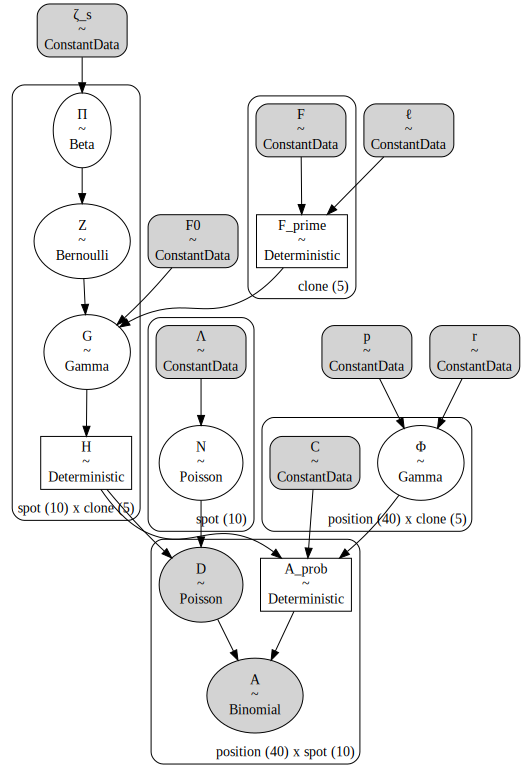

In [5]:
np.random.seed(234)
mock_tumor_data = TumoroscopeData(
    K=5,
    S=10,
    M=40,
    F=np.ones(5) / 5.0,
    cell_counts=np.random.randint(1, 20, size=10),
    C=np.random.beta(2, 2, size=(40, 5)),
    D_obs=np.random.randint(2, 20, size=(40, 10)),
    A_obs=np.random.randint(2, 20, size=(40, 10)),
)
pm.model_to_graphviz(tumoroscope(mock_tumor_data))

As described in the manuscript, there is also a "fixed" version of the model where the number of cells per spot is assumed correct instead of modeled as a noisy estimate. 

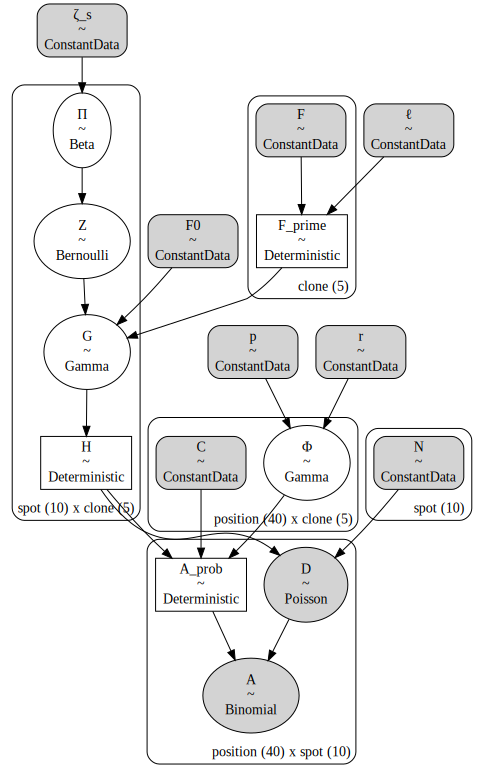

In [6]:
pm.model_to_graphviz(tumoroscope(mock_tumor_data, fixed=True))

## Prior predictive sampling

Before testing the models on simulated data, I conducted a prior predictive sampling to ensure the model could be sampled from.

In [7]:
example_input_data = TumoroscopeData(
    K=5,
    S=10,
    M=40,
    F=np.array([0.01, 0.05, 0.15, 0.3, 0.49]),
    cell_counts=np.ones(10) * 5,
    C=np.random.choice([0, 0.5, 1.0], size=(40, 5), replace=True),
    D_obs=None,
    A_obs=None,
    r=0.19,
    p=1,
)

with tumoroscope(example_input_data) as m:
    prior_pred = pm.sample_prior_predictive(
        500,
        var_names=["D", "A", "H", "G", "Z", "Π", "Φ", "N", "A_prob"],
        random_seed=123,
    )

Sampling: [A, D, G, N, Z, Π, Φ]


In [8]:
prior_pred.constant_data["Λ"].values

array([5., 5., 5., 5., 5., 5., 5., 5., 5., 5.])

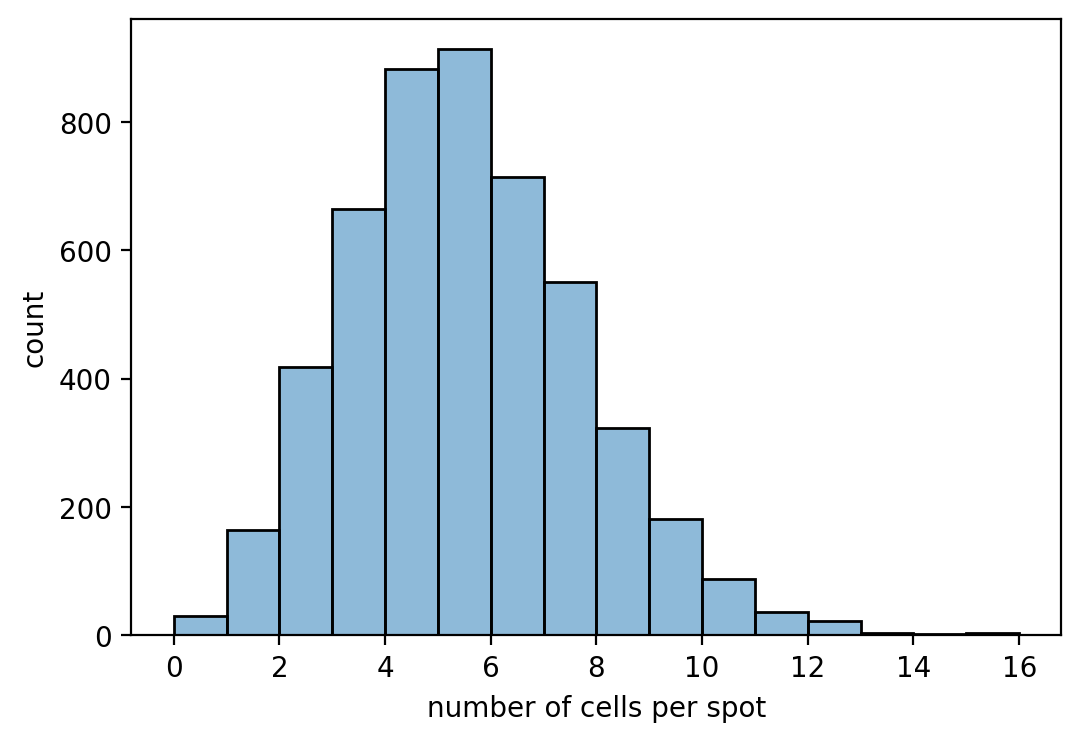

In [9]:
_, ax = plt.subplots(figsize=(6, 4))
sns.histplot(prior_pred.prior["N"].values.flatten(), alpha=0.5, binwidth=1, ax=ax)
ax.set_xlabel("number of cells per spot")
ax.set_ylabel("count")
plt.show()

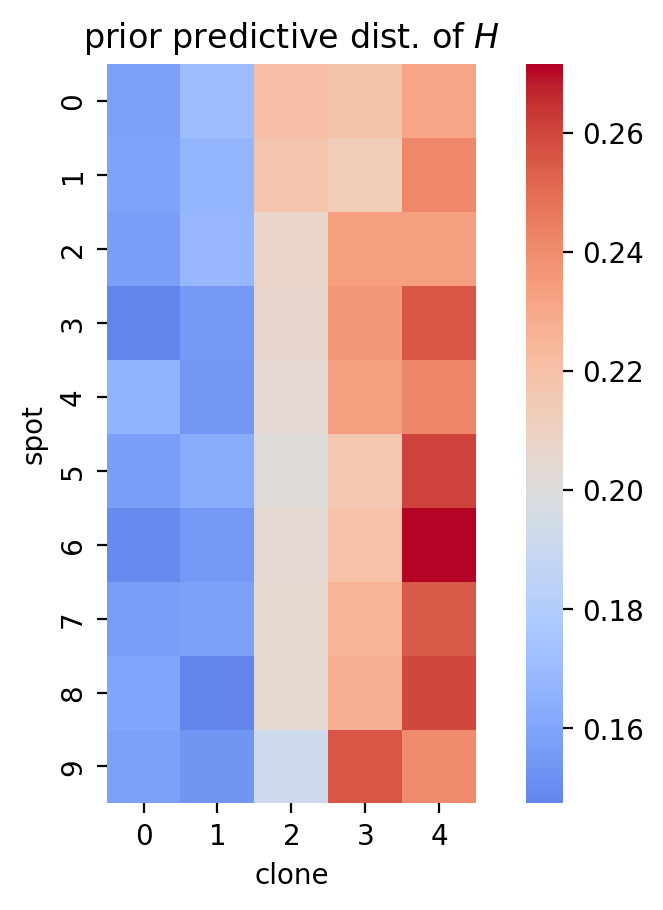

In [10]:
H_mean = prior_pred.prior["H"].values.squeeze().mean(axis=0)
ax = sns.heatmap(
    data=H_mean, cmap="coolwarm", center=1 / mock_tumor_data.K, square=True
)
ax.set_xlabel("clone")
ax.set_ylabel("spot")
ax.set_title("prior predictive dist. of $H$")
plt.show()

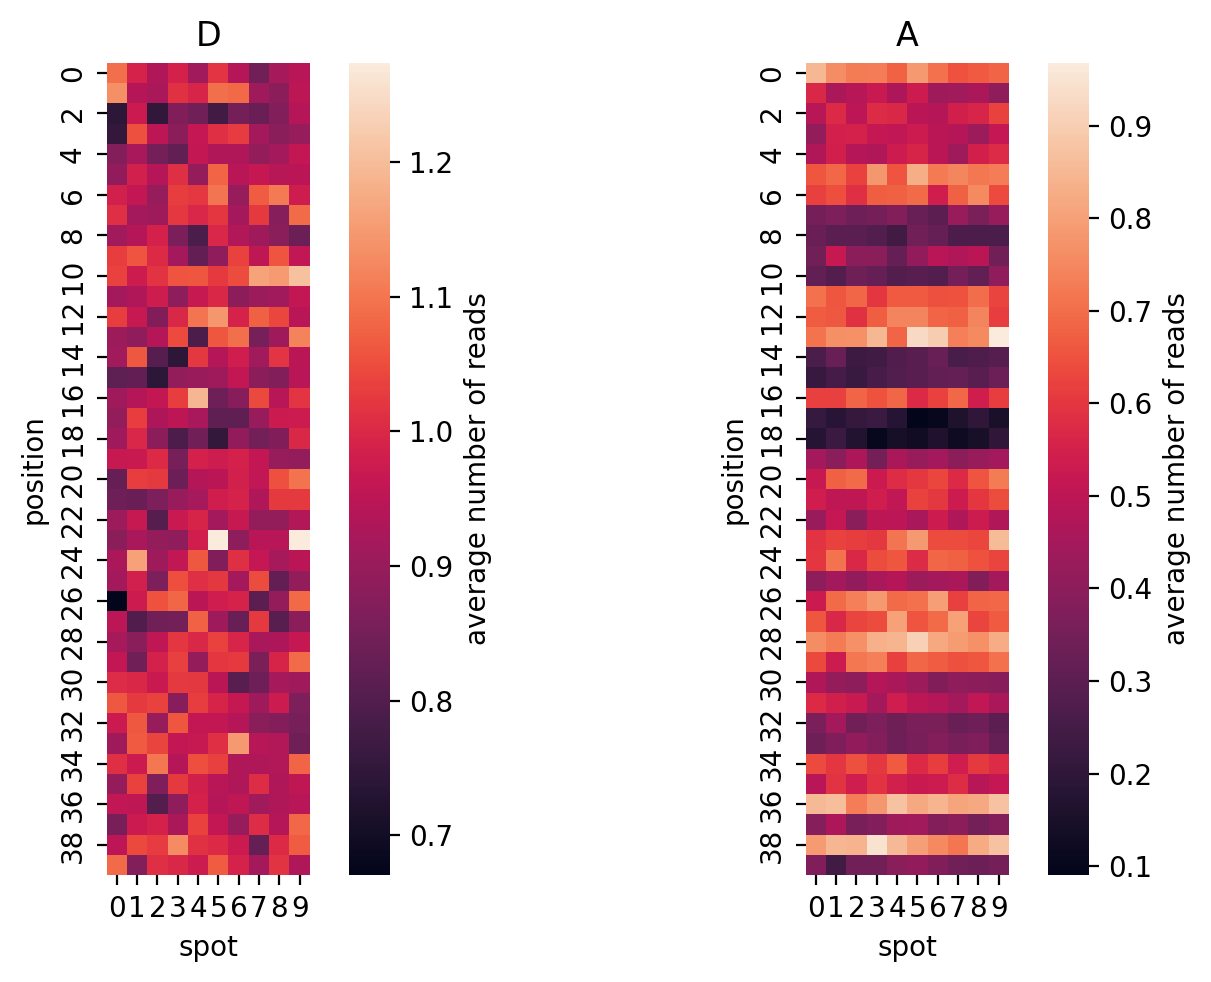

In [11]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 5))
for ax, var_name in zip(axes, ["D", "A"]):
    var_prior_mean = prior_pred.prior[var_name].mean(axis=(0, 1)).values
    sns.heatmap(
        var_prior_mean,
        square=True,
        cbar_kws={"label": "average number of reads"},
        ax=ax,
    )
    ax.set_xlabel("spot")
    ax.set_ylabel("position")
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

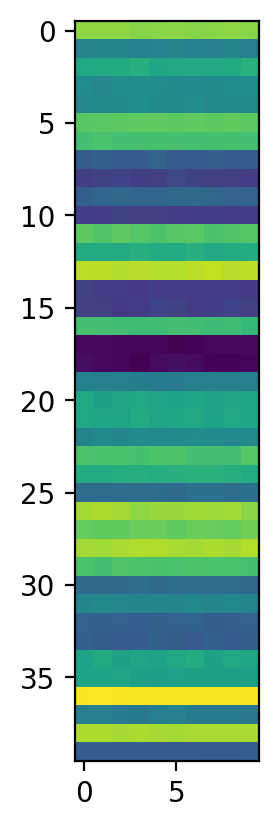

In [12]:
plt.imshow(prior_pred.prior["A_prob"].mean(dim=("chain", "draw")))

Average number of reads *per spot*.

In [13]:
prior_pred.prior["D"].mean(axis=(0, 1)).sum(axis=0).values

array([37.208, 38.7  , 37.204, 38.064, 38.834, 39.186, 38.212, 37.386,
       37.636, 39.206])

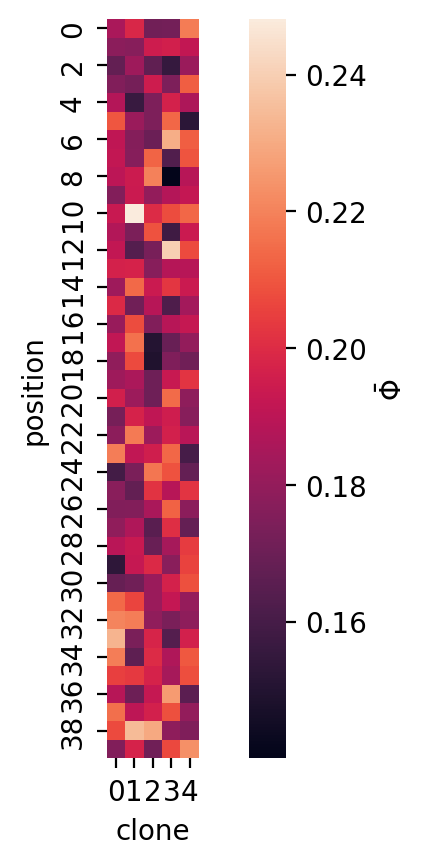

In [14]:
phi_prior_mean = prior_pred.prior["Φ"].mean(axis=(0, 1)).values
ax = sns.heatmap(phi_prior_mean, square=True, cbar_kws={"label": r"$\bar{\Phi}$"})
ax.set_xlabel("clone")
ax.set_ylabel("position")
plt.show()

## Simulation experiments

### Simple simulation

This simulation is purposefully simple to give the model the best chance at working if it correctly specified.
There are only two clones, one with mutations and one with none.
There are many cells per spot to increase the odds of mixtures of clones.
The number of reads per position per clone is fixed at four per cell and the number of alternative reads is perfectly aligned with the zygosity of the mutation in the clone; the zygosity is also limited to 0.5 or 1.

In [15]:
# Set seed for reproducible results.
np.random.seed(8383)

# Set true underlying constants.
N_CLONES = 2
N_SPOTS = 20
n_positions = 300  # changes below depending on random sampling

# Number of cells counted in each spot between 10 and 20 cells.
cell_counts = np.random.randint(10, 20, size=N_SPOTS)

# True mutations for each clone.
clone_mutations = np.hstack(
    [np.random.binomial(1, p, size=(n_positions, 1)) for p in [0.0, 0.5]]
)
# Drop positions without any mutations.
clone_mutations = clone_mutations[clone_mutations.sum(axis=1) > 0.0, :]
clone_mutations = clone_mutations[clone_mutations.mean(axis=1) < 1.0, :]
n_positions = clone_mutations.shape[0]
print(f"Number of positions: {n_positions}")

# Assign probability distribution over spots for each clone.
clone_props_params = [(1, 3), (3, 1)]
clone_ratios = np.array([0.5, 0.5])
spots_x = np.linspace(0, 1, N_SPOTS)
clone_proportions = np.hstack(
    [scipy.stats.beta(a, b).pdf(spots_x)[:, None] for a, b in clone_props_params]
)
clone_proportions = clone_proportions * clone_ratios
clone_proportions = clone_proportions / clone_proportions.sum(axis=1)[:, None]

# True fraction of clones taken from the underlying distributions.
F = np.array([scipy.stats.beta(a, b).pdf(spots_x).sum() for a, b in clone_props_params])
F = F * clone_ratios
F = F / F.sum()

_cell_labels: list[tuple[int, int, int]] = []
clones = np.arange(N_CLONES)
for spot_i in range(N_SPOTS):
    for cell_j in range(cell_counts[spot_i]):
        clone = np.random.choice(clones, size=1, p=clone_proportions[spot_i, :])[0]
        _cell_labels.append((spot_i, cell_j, clone))
cell_labels = pd.DataFrame(_cell_labels, columns=["spot", "cell", "clone"])

# Save underlying values for later.
simple_sim_truth: Final[dict[str, Any]] = {
    "cell_labels": cell_labels.copy(),
    "clone_proportions": clone_proportions.copy(),
}

cell_labels.head()

Number of positions: 150


spot  cell  clone
0     0     0      0
1     0     1      0
2     0     2      0
3     0     3      0
4     0     4      0

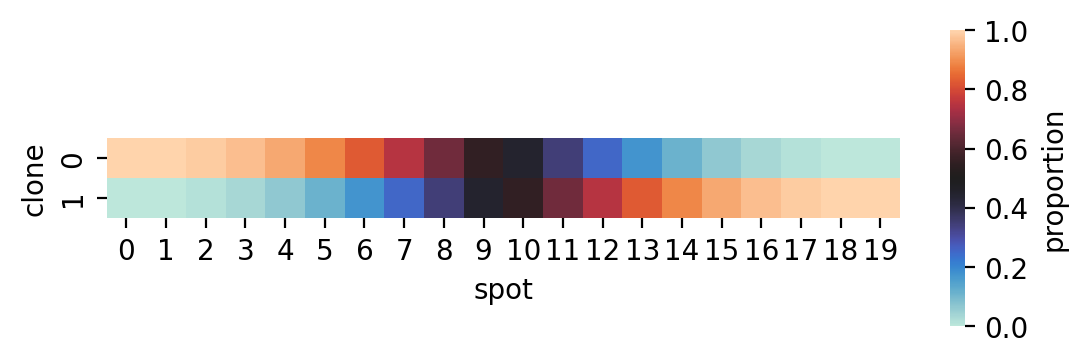

In [16]:
ax = sns.heatmap(
    clone_proportions.T,
    cmap="icefire",
    center=0.5,
    vmin=0,
    vmax=1.0,
    square=True,
    cbar_kws={"shrink": 0.4, "label": "proportion"},
)
ax.set_xlabel("spot")
ax.set_ylabel("clone")
plt.show()

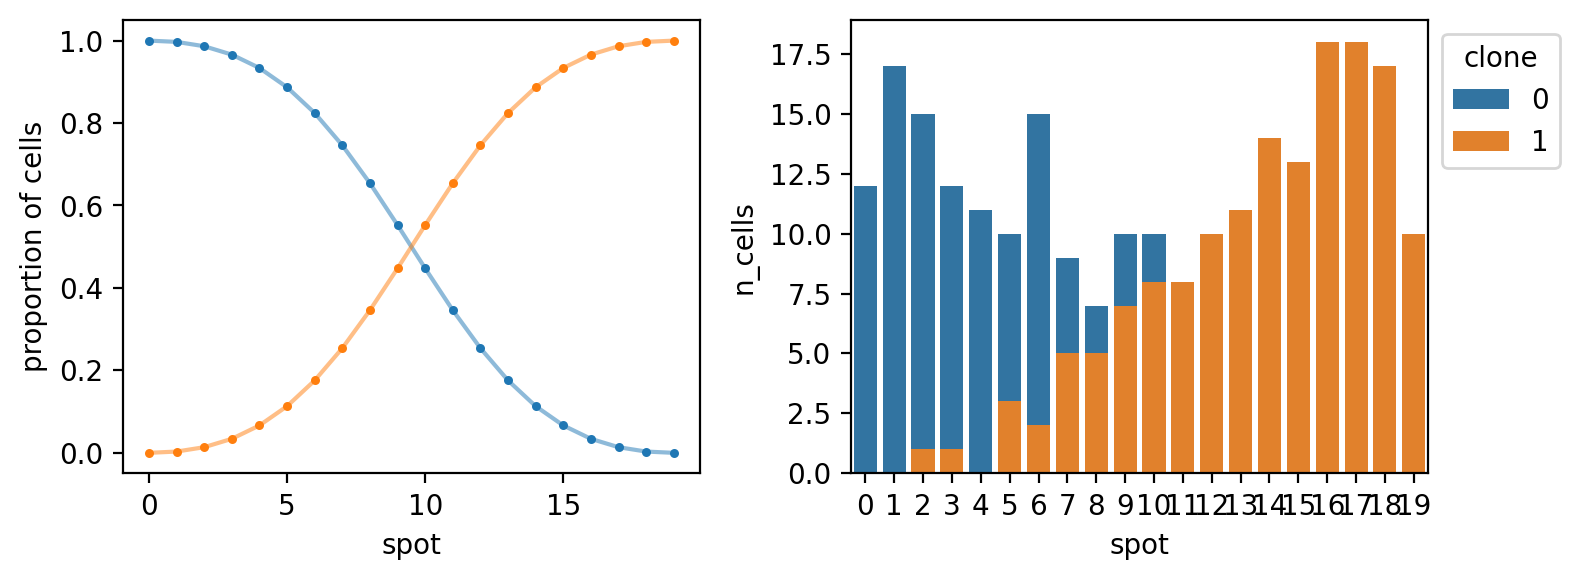

In [17]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 3))

ax = axes[0]
for i in range(clone_proportions.shape[1]):
    x = np.arange(clone_proportions.shape[0])
    ax.plot(x, clone_proportions[:, i], label=f"{i}", alpha=0.5)
    ax.scatter(x, clone_proportions[:, i], s=5)

ax.set_xlabel("spot")
ax.set_ylabel("proportion of cells")

ax = axes[1]
clones_per_spot = (
    cell_labels.groupby(["spot", "clone"])
    .count()
    .reset_index()
    .rename(columns={"cell": "n_cells"})
    .astype({"clone": "category"})
)
ax.set_ylabel("number of cells")

sns.barplot(
    data=clones_per_spot, x="spot", y="n_cells", hue="clone", ax=ax, dodge=False
)
ax.legend(loc="upper left", bbox_to_anchor=(1, 1), title="clone")
fig.tight_layout()
plt.show()

Actual clone proportions vs. the randomly sampled clone proportions averaging across spots:

In [18]:
F, clone_proportions.mean(axis=0)

(array([0.5, 0.5]), array([0.5, 0.5]))

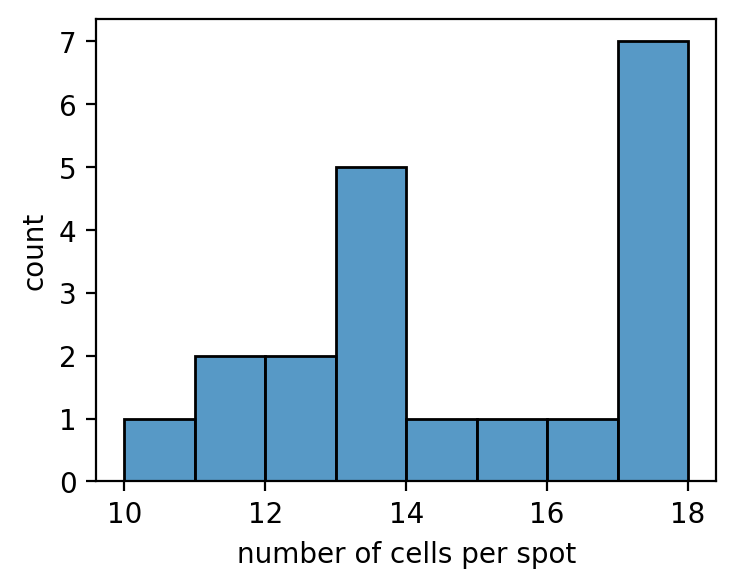

In [19]:
_, ax = plt.subplots(figsize=(4, 3))
sns.histplot(cell_counts.flatten(), binwidth=1, ax=ax)
ax.set_xlabel("number of cells per spot")
ax.set_ylabel("count")
plt.show()

/usr/local/Caskroom/miniconda/base/envs/pymc-tumoroscope/lib/python3.10/site-packages/seaborn/matrix.py:720: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(0, max_dependent_coord * 1.05)


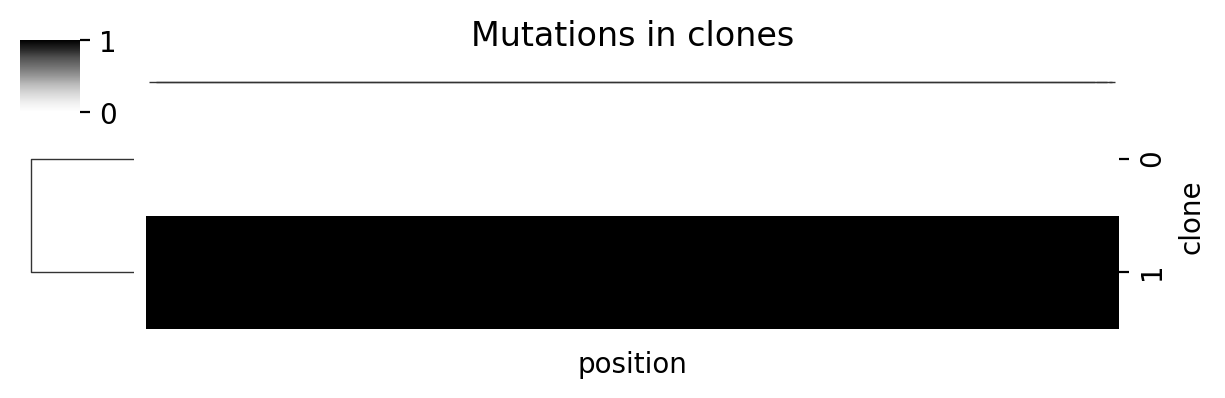

In [20]:
cg = sns.clustermap(
    clone_mutations.T, figsize=(6, 2), dendrogram_ratio=(0.1, 0.15), cmap="Greys"
)
cg.ax_heatmap.set_xlabel("position")
cg.ax_heatmap.set_ylabel("clone")
cg.ax_heatmap.set_xticklabels([])
cg.ax_heatmap.tick_params("x", size=0)
cg.ax_col_dendrogram.set_title("Mutations in clones")
plt.show()

In [21]:
np.random.seed(44)

# Randomly assign zygosity per position for each clone.
zygosity = np.random.choice([0.5, 1.0], size=(n_positions, N_CLONES)) * clone_mutations

# For each cell in each spot, there are 4 reads.
# The number of alternative reads is perfectly calculated based on the
#   zygosity of the clone at the position.

alt_read_counts = np.zeros((n_positions, N_SPOTS, N_CLONES))
tot_read_counts = np.zeros((n_positions, N_SPOTS, N_CLONES))

clone_cell_counts_per_spot = (
    cell_labels.groupby(["spot", "clone"])["cell"]
    .count()
    .reset_index()
    .rename(columns={"cell": "n_cells"})
)

for _, row in clone_cell_counts_per_spot.iterrows():
    tot_reads = (np.ones(n_positions) * 4 * row["n_cells"]).astype(int)
    alt_reads = np.round(zygosity[:, row["clone"]] * tot_reads).astype(int)
    tot_read_counts[:, row["spot"], row["clone"]] = tot_reads
    alt_read_counts[:, row["spot"], row["clone"]] = alt_reads

alt_read_counts = alt_read_counts.sum(axis=2)
tot_read_counts = tot_read_counts.sum(axis=2)
alt_read_counts.shape

(150, 20)

In [22]:
avg_read_cts = tot_read_counts.sum(axis=0).mean()
print(f"average reads per spot: {avg_read_cts:0.2f}")

average reads per spot: 8640.00


For this simulation, the total counts is $4 \times n_\text{cells}$ in each position per spot.
The alternative reads is this number multiplied by the zygosity of the clone and fraction of the clone in the spot.
Clone 0 has no mutations so the alternative read count fades with the number of clone 1 cells.

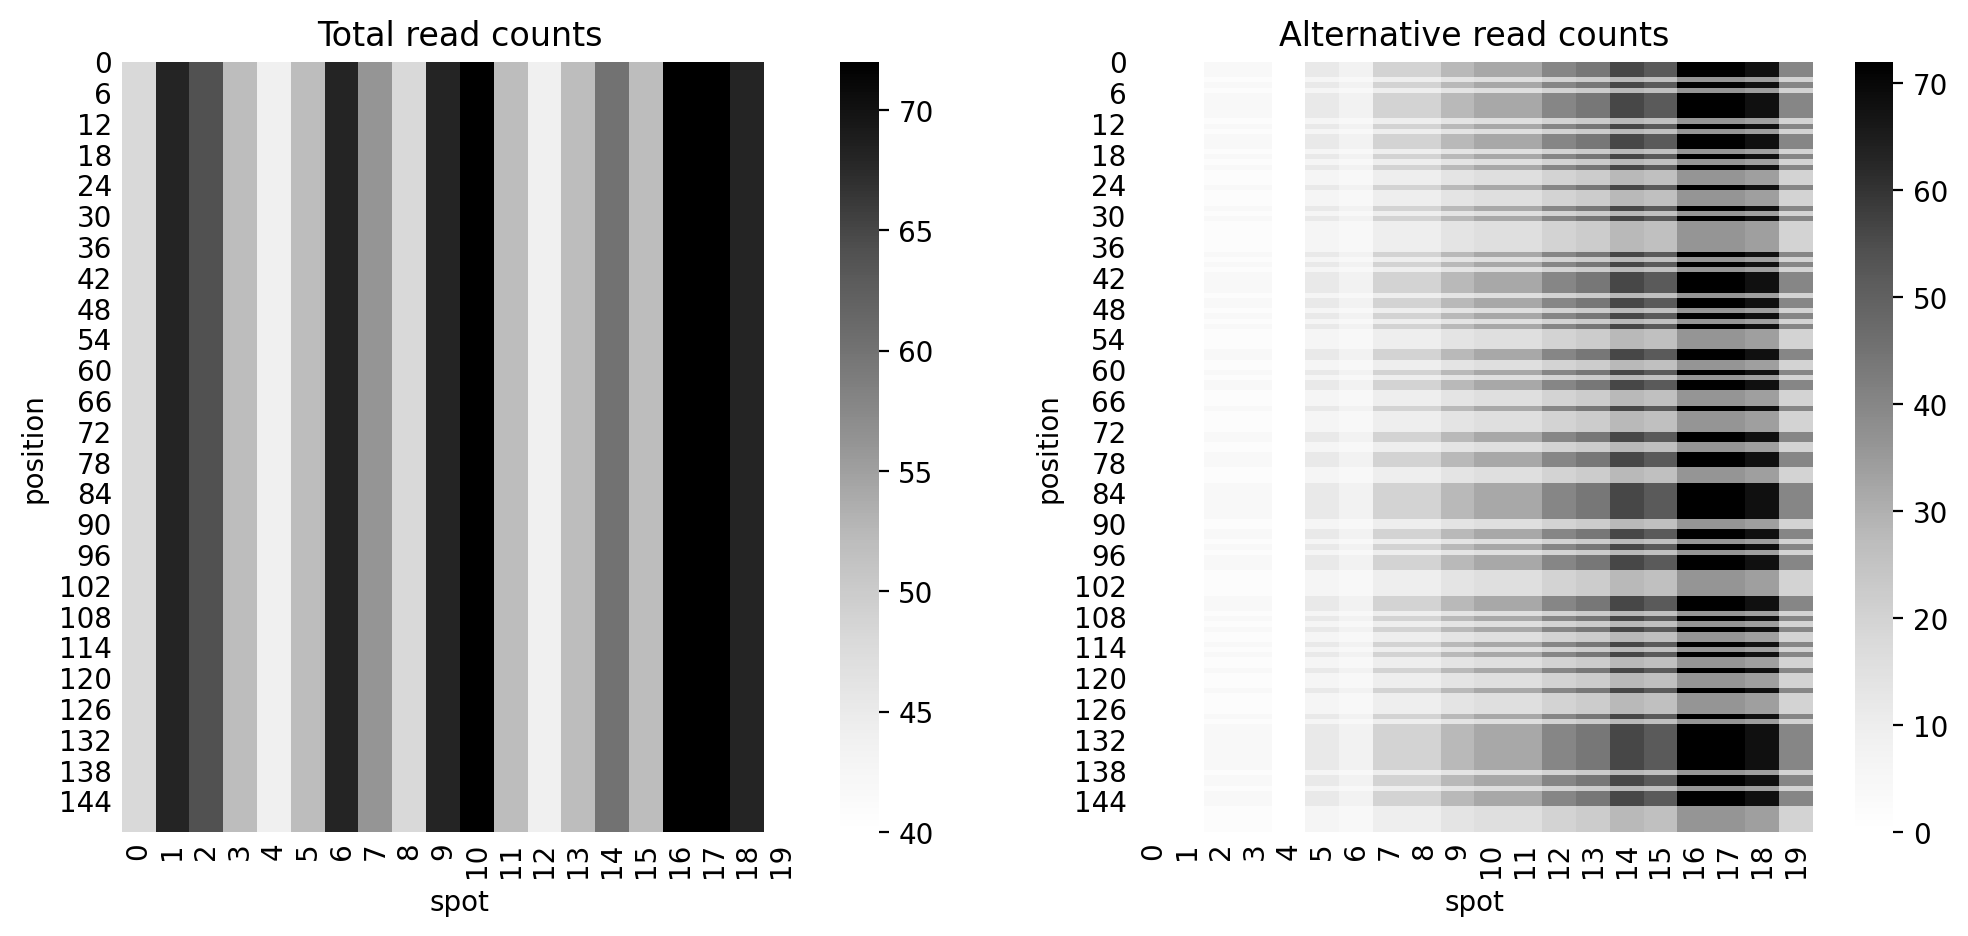

In [23]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 5))
sns.heatmap(tot_read_counts, cmap="Greys", ax=axes[0])
axes[0].set_title("Total read counts")
sns.heatmap(alt_read_counts, cmap="Greys", ax=axes[1])
axes[1].set_title("Alternative read counts")

for ax in axes:
    ax.tick_params(size=0)
    ax.set_xlabel("spot")
    ax.set_ylabel("position")

plt.show()

In [24]:
sim_data = TumoroscopeData(
    K=N_CLONES,
    S=N_SPOTS,
    M=n_positions,
    F_0=1,
    F=F,
    cell_counts=cell_counts,
    C=zygosity,
    D_obs=tot_read_counts,
    A_obs=alt_read_counts,
    zeta_s=N_CLONES * 2,
    r=1,
    p=1,
)

sim_trace_fp = models_dir / "simulation-trace.netcdf"
if False and sim_trace_fp.exists():
    print("Removing trace cache.")
    os.remove(sim_trace_fp)

if sim_trace_fp.exists():
    print("Retrieving cached posterior.")
    sim_trace = az.from_netcdf(sim_trace_fp)
else:
    with tumoroscope(sim_data, fixed=False):
        sim_trace = pm.sample(
            draws=1000, tune=1000, chains=4, cores=4, random_seed=10, target_accept=0.9
        )
        pm.sample_posterior_predictive(
            sim_trace, random_seed=7348, extend_inferencedata=True
        )
    sim_trace.to_netcdf(sim_trace_fp)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [Π, G, Φ]
>BinaryGibbsMetropolis: [Z]
>Metropolis: [N]


/usr/local/Caskroom/miniconda/base/envs/pymc-tumoroscope/lib/python3.10/site-packages/pymc/step_methods/metropolis.py:296: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/usr/local/Caskroom/miniconda/base/envs/pymc-tumoroscope/lib/python3.10/site-packages/pymc/step_methods/metropolis.py:296: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/usr/local/Caskroom/miniconda/base/envs/pymc-tumoroscope/lib/python3.10/site-packages/pymc/step_methods/metropolis.py:296: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/usr/local/Caskroom/miniconda/base/envs/pymc-tumoroscope/lib/python3.10/site-packages/pymc/step_methods/metropolis.py:296: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 204 seconds.
/usr/local/Caskroom

In [25]:
n_divs = sim_trace.sample_stats.diverging.sum(axis=1).values
print(f"Number of divergences per chain: {n_divs}")

Number of divergences per chain: [0 0 0 0]


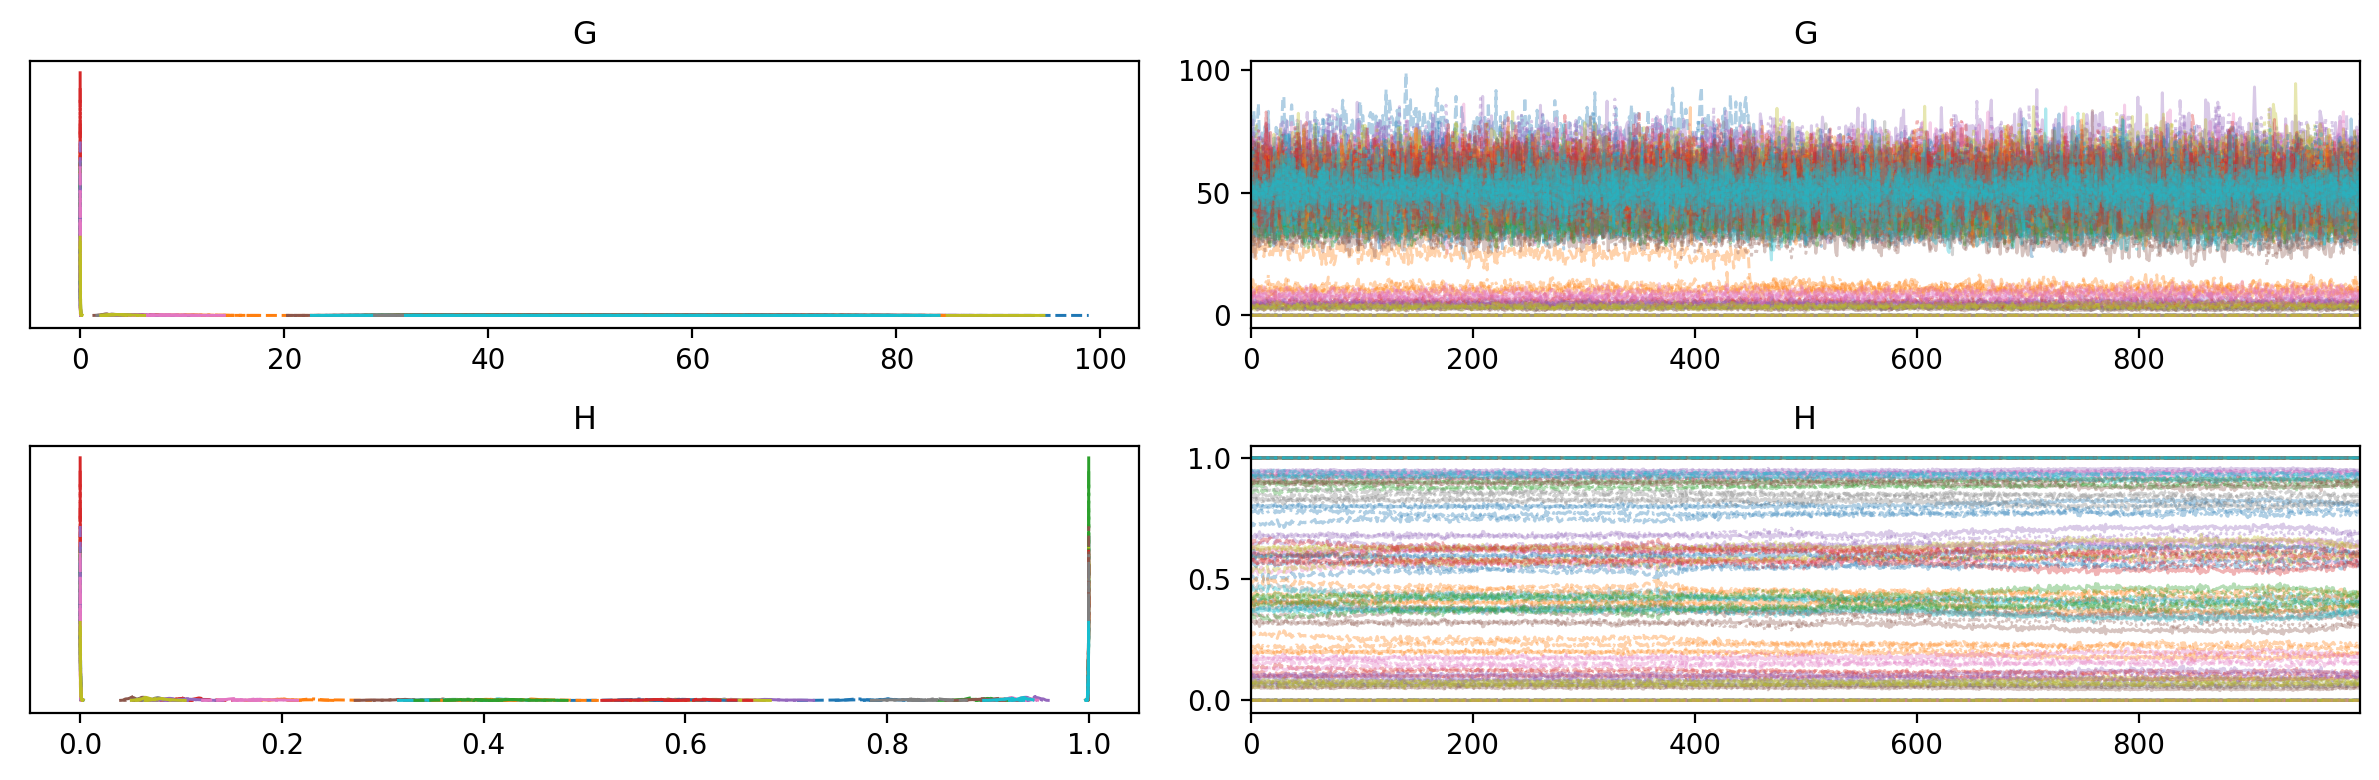

In [26]:
az.plot_trace(sim_trace, var_names=["G", "H"])
plt.tight_layout()

The proportions of cells are estimated very well.

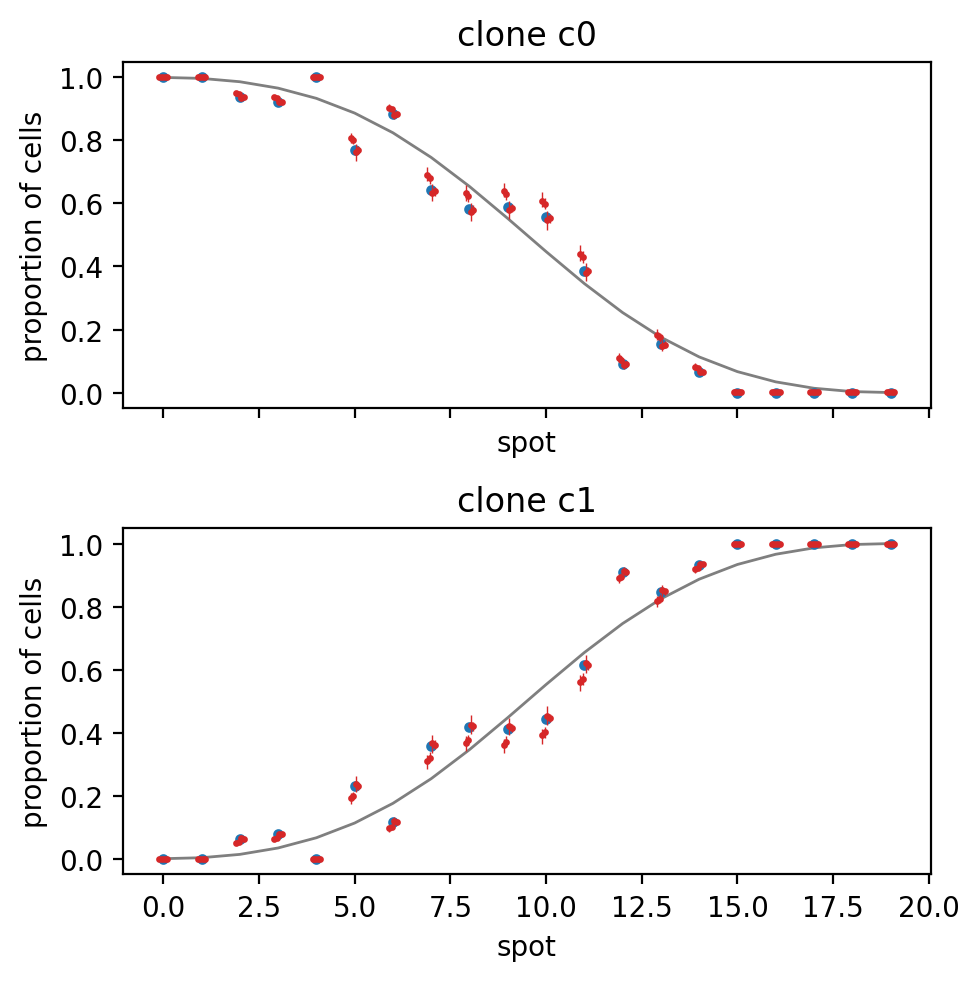

In [27]:
def _frac_clone(s: pd.Series, k: int) -> float:
    return np.mean(s == k)


fig, axes = plt.subplots(nrows=sim_data.K, figsize=(5, 2.5 * sim_data.K), sharex=True)
for clone_i, ax in enumerate(axes.flatten()):
    clone = f"c{clone_i}"
    ax.set_title(f"clone {clone}")

    # Plot true fraction of clones at each spot.
    true_clone_frac = cell_labels.groupby(["spot"])["clone"].apply(
        _frac_clone, k=clone_i
    )
    ax.scatter(
        true_clone_frac.index.tolist(),
        true_clone_frac.values.tolist(),
        c="tab:blue",
        s=8,
        zorder=10,
    )

    # Plot true underlying proportion of clones at each spot.
    spot = np.arange(sim_data.S)
    ax.plot(spot, clone_proportions[:, clone_i], c="tab:grey", lw=1, zorder=5)

    # Plot posterior.
    H = sim_trace.posterior["H"].sel(clone=[clone])
    dx = np.linspace(-0.1, 0.1, len(H.coords["chain"]))
    for chain in H.coords["chain"]:
        _x = spot + dx[chain]
        ax.scatter(_x, H.sel(chain=chain).mean(axis=(0)), c="tab:red", s=2, zorder=20)
        _hdi = az.hdi(H, coords={"chain": [chain]})["H"].values.squeeze()
        ax.vlines(
            x=_x, ymin=_hdi[:, 0], ymax=_hdi[:, 1], lw=0.5, zorder=10, color="tab:red"
        )
    ax.set_xlabel("spot")
    ax.set_ylabel("proportion of cells")

fig.tight_layout()
plt.show()

The estimated number of cells is proportional to the true number, through tends to be high.
I'm not sure why this is.

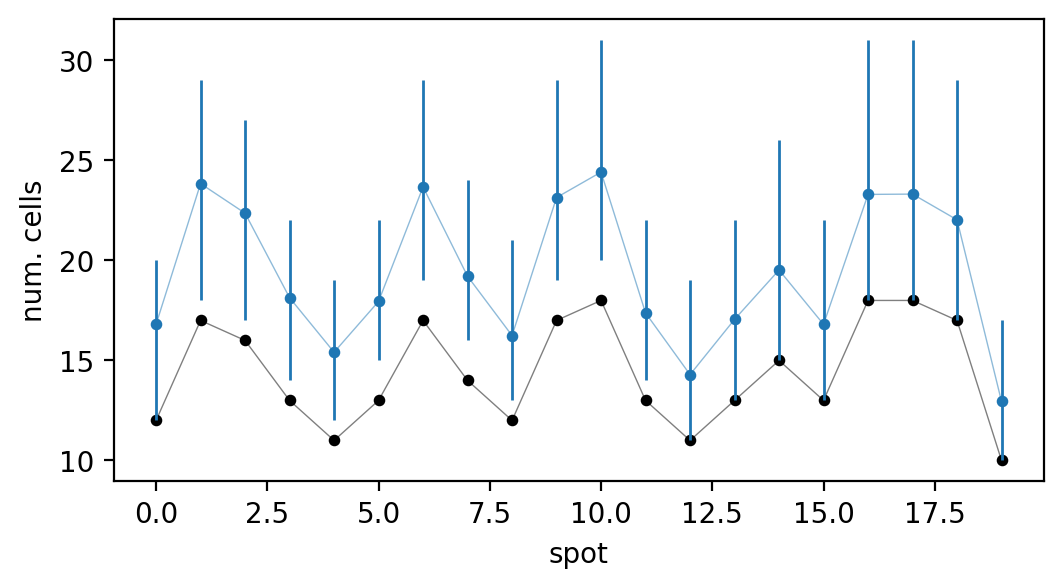

In [28]:
cell_counts_post = az.summary(sim_trace, var_names=["N"]).assign(
    truth=sim_data.cell_counts
)

_, ax = plt.subplots(figsize=(6, 3))
np.arange(len(cell_counts_post))
ax.scatter(x, cell_counts_post["mean"], c="tab:blue", zorder=10, s=10)
ax.plot(x, cell_counts_post["mean"], c="tab:blue", zorder=2, lw=0.5, alpha=0.5)
ax.vlines(
    x,
    cell_counts_post["hdi_5.5%"],
    cell_counts_post["hdi_94.5%"],
    color="tab:blue",
    zorder=10,
    lw=1,
)
ax.set_xlabel("spot")
ax.set_ylabel("num. cells")
ax.scatter(x, cell_counts_post["truth"], c="k", zorder=5, s=10)
ax.plot(x, cell_counts_post["truth"], c="k", zorder=2, lw=0.5, alpha=0.5)

Check accuracy of $Z$, a variable indicating if clone $k$ is present in spot $s$, by checking if the mean of the posterior distribution is correct.

In [30]:
clone_counts = (
    cell_labels.astype({"clone": "category"}).groupby(["spot", "clone"]).count()
)
Z_post_summary = az.summary(
    sim_trace, var_names=["Z"], kind="stats", stat_focus="median"
).assign(truth=clone_counts["cell"].values > 0)
Z_accuracy = np.mean(Z_post_summary["median"] == Z_post_summary["truth"])
print(f"accuracy of Z: {Z_accuracy:0.2f}")

accuracy of Z: 0.82


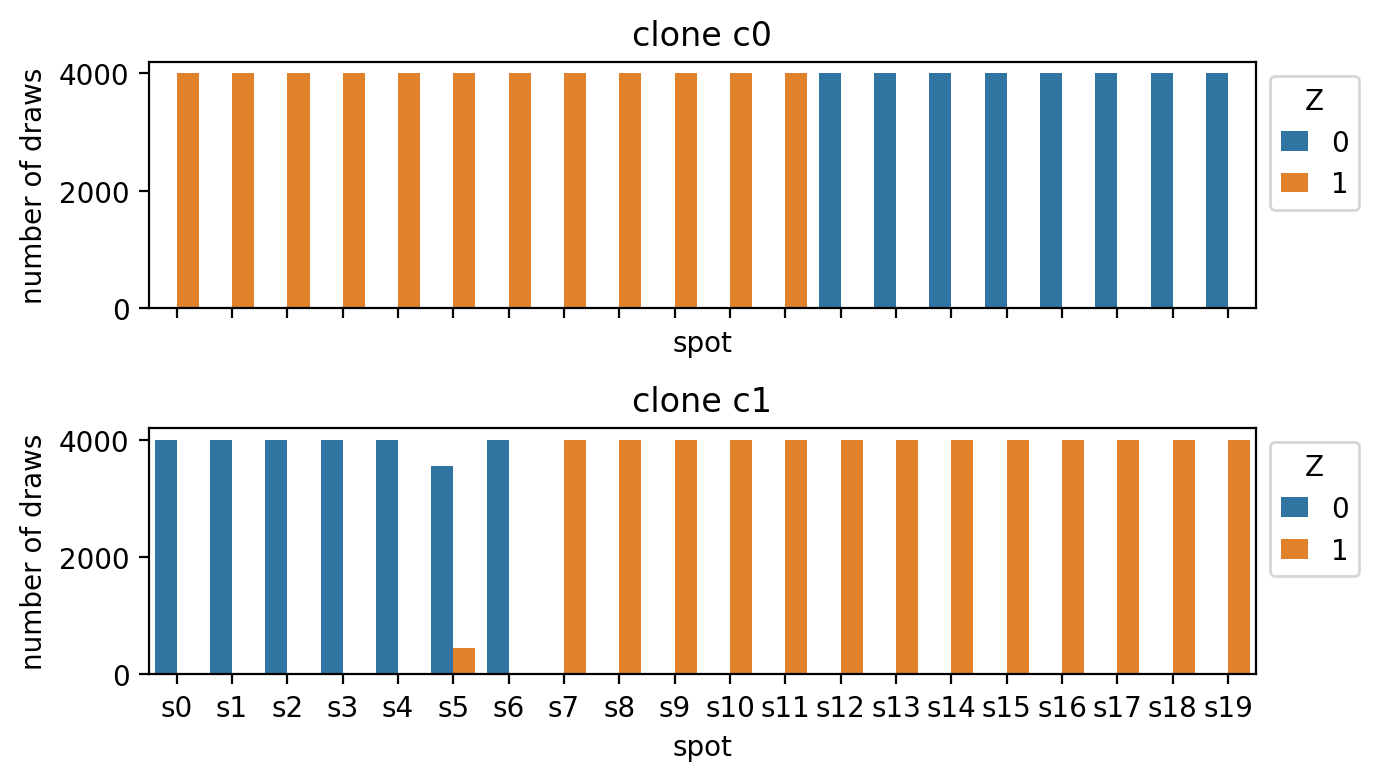

In [31]:
Z_dist = (
    sim_trace.posterior["Z"]
    .to_dataframe()
    .reset_index()
    .groupby(["spot", "clone", "Z"])["draw"]
    .count()
    .reset_index()
)
Z_dist["spot"] = pd.Categorical(Z_dist["spot"], sim_trace.posterior.coords["spot"])

fig, axes = plt.subplots(
    nrows=2, ncols=ceil(sim_data.K / 2), figsize=(7, 4), sharex=True
)
for ax, (clone, Z_dist_k) in zip(axes.flatten(), Z_dist.groupby("clone")):
    ax.set_title(f"clone {clone}")
    sns.barplot(data=Z_dist_k, x="spot", y="draw", hue="Z", ax=ax)
    ax.legend(loc="upper left", bbox_to_anchor=(1, 1), title="Z", handlelength=1)
    ax.set_xlabel("spot")
    ax.set_ylabel("number of draws")

fig.tight_layout()
plt.show()

The observed and estimated alternative read counts matched very well.

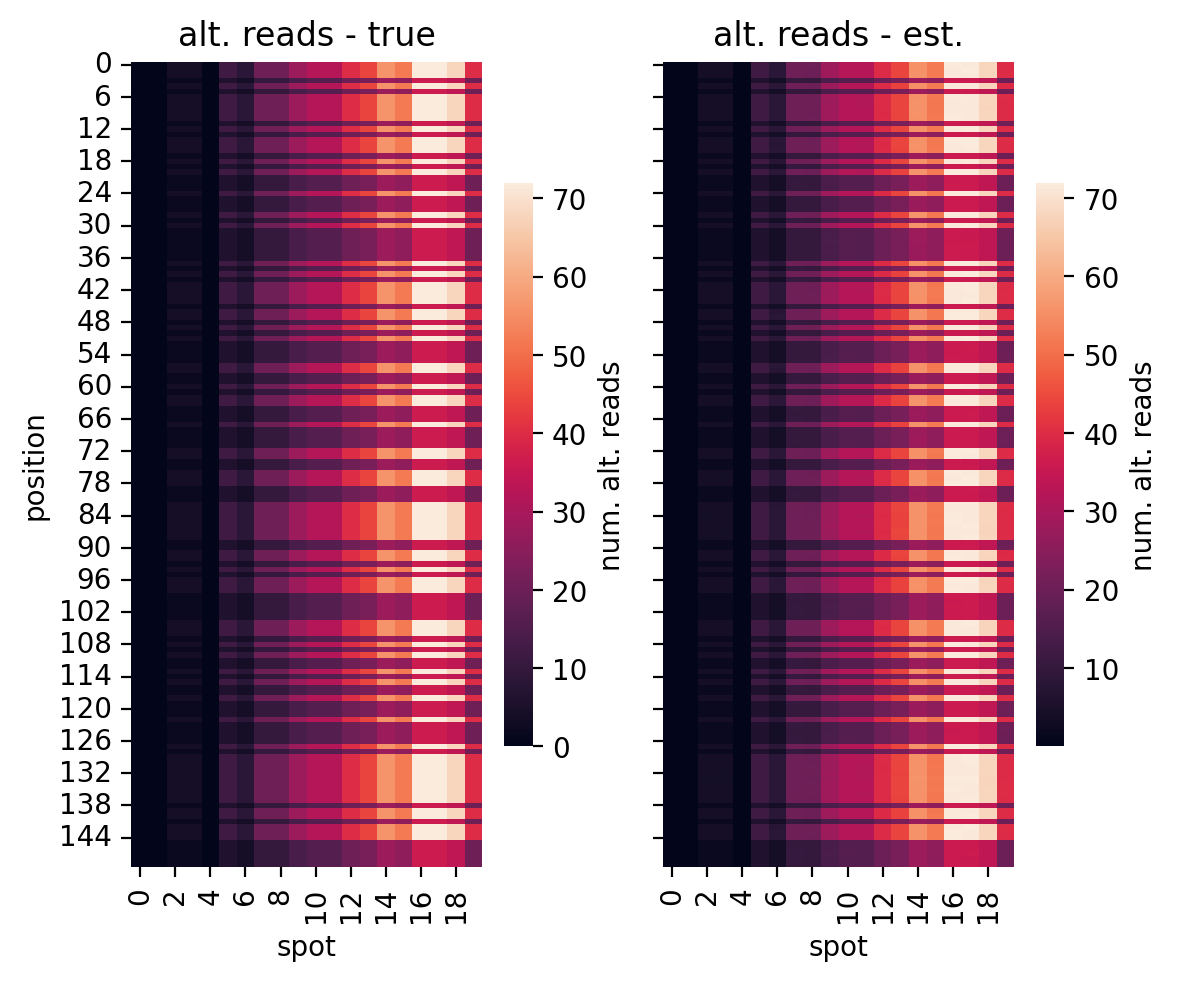

In [32]:
fig, axes = plt.subplots(ncols=2, figsize=(6, 5), sharey=True)
A_prob = sim_trace.posterior_predictive["A"].mean(dim=("chain", "draw")).values
# axes[0].imshow(A_prob)
sns.heatmap(
    sim_data.A_obs, ax=axes[0], cbar_kws={"shrink": 0.7, "label": "num. alt. reads"}
)
sns.heatmap(A_prob, ax=axes[1], cbar_kws={"shrink": 0.7, "label": "num. alt. reads"})
axes[0].set_xlabel("spot")
axes[1].set_xlabel("spot")
axes[0].set_ylabel("position")

axes[0].set_title("alt. reads - true")
axes[1].set_title("alt. reads - est.")
fig.tight_layout()

### Realistic simulation

This simulations is more complex and attempts to be more realistic.
This means increasing the number of clones, mutations/positions, and spots, while reducing the number of cells per spot and read coverage.
For simplicity, I'm not going to add noise to the number of cells, but I will add randomness to the read coverage and alternate read counts.
The underlying simulation parameters were adjusted per the description in the pre-print manuscript.

In [33]:
# Set seed for reproducible results.
np.random.seed(8383)

# Set true underlying constants.
N_CLONES = 5
N_SPOTS = 30
n_positions = 60  # number changes below depending on random sampling

# True mutations for each clone.
clone_mutations = np.random.binomial(1, 0.136, size=(n_positions, N_CLONES))
# Drop positions without any mutations.
clone_mutations = clone_mutations[clone_mutations.sum(axis=1) > 0.0, :]
clone_mutations = clone_mutations[clone_mutations.mean(axis=1) < 1.0, :]
n_positions = clone_mutations.shape[0]
print(f"Number of positions: {n_positions}")

# Number of cells counted in each spot between 1 and 4 cells.
cell_counts = np.random.randint(1, 5, size=N_SPOTS)
_cell_labels = []
for spot_s in range(N_SPOTS):
    for cell_i in range(cell_counts[spot_s]):
        _cell_labels.append((spot_s, cell_i, np.random.randint(N_CLONES)))

cell_labels = pd.DataFrame(_cell_labels, columns=["spot", "cell", "clone"])
cell_labels.head()

Number of positions: 32


spot  cell  clone
0     0     0      4
1     0     1      3
2     0     2      3
3     1     0      1
4     2     0      4

In [34]:
clone_proportions = cell_labels.groupby("clone")["cell"].count().values
clone_proportions = clone_proportions / clone_proportions.sum()
clone_proportions

array([0.17910448, 0.13432836, 0.29850746, 0.14925373, 0.23880597])

In [35]:
real_sim_truth: Final[dict[str, Any]] = {
    "cell_labels": cell_labels.copy(),
    "clone_proportions": clone_proportions.copy(),
}

Below is a visualization of the cells in each spot.
Each box is a spot and each point a cell colored by its clone label.

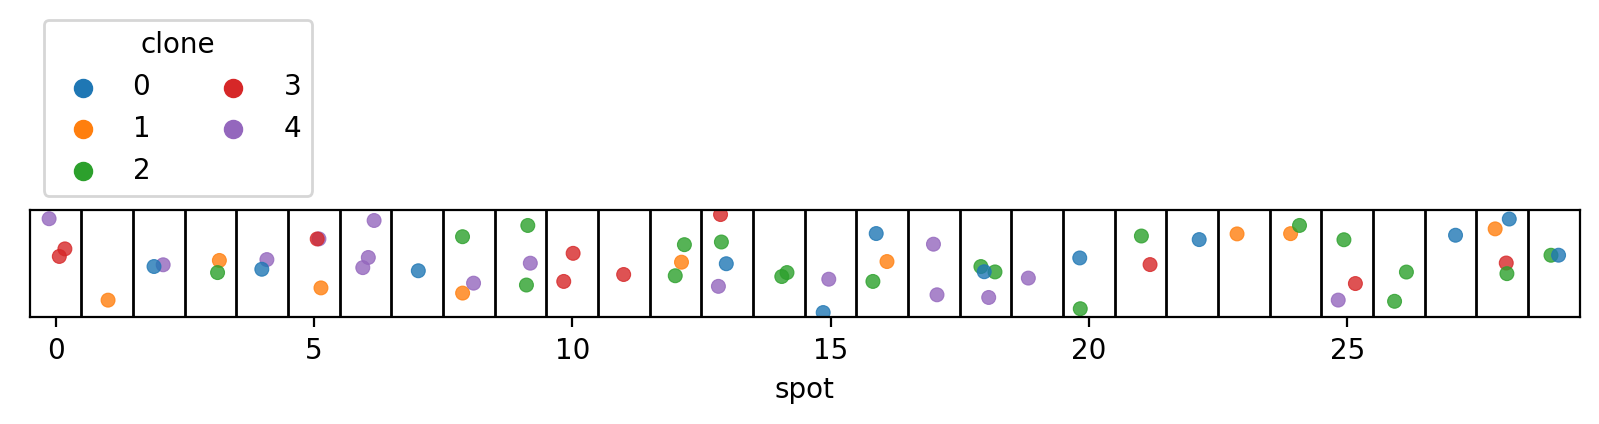

In [36]:
np.random.seed(3)
plot_df = (
    cell_labels.copy()
    .assign(
        y=lambda d: np.random.normal(0, 0.5, len(d)),
        x=lambda d: d["spot"] + np.random.uniform(-0.2, 0.2, len(d)),
    )
    .astype({"clone": "category"})
)
_, ax = plt.subplots(figsize=(10, 0.7))
sns.scatterplot(
    data=plot_df, x="x", y="y", hue="clone", ax=ax, alpha=0.8, edgecolor=None, s=25
)
for i in range(1, N_SPOTS):
    ax.axvline(i - 0.5, lw=1, color="k")
ax.set_xlim(-0.5, N_SPOTS - 0.5)
ax.set_xlabel("spot")
ax.set_ylabel(None)
ax.set_yticks([])
ax.legend(loc="lower left", bbox_to_anchor=(0, 1), title="clone", ncol=2)
plt.show()

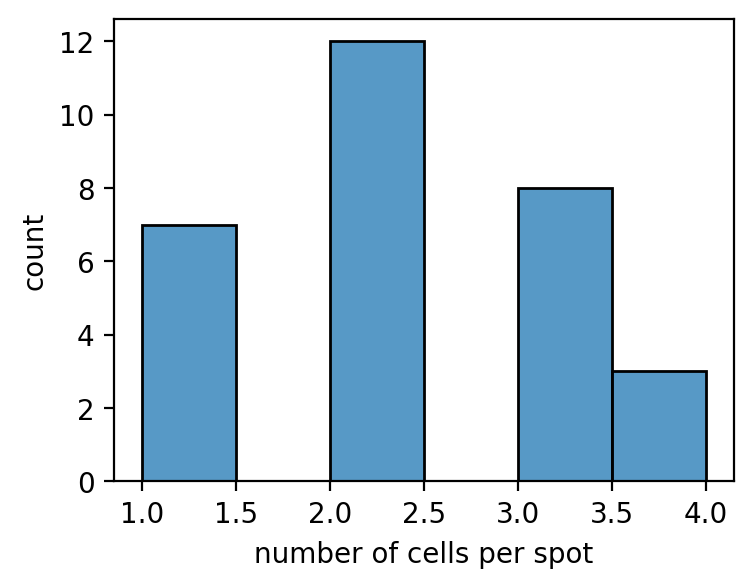

In [37]:
_, ax = plt.subplots(figsize=(4, 3))
sns.histplot(cell_counts.flatten(), binwidth=0.5, ax=ax)
ax.set_xlabel("number of cells per spot")
ax.set_ylabel("count")
plt.show()

The mutations are more complex this time with the same mutations present in multiple clones.
This adds some uncertainty to which alternative reads correspond to which clones.

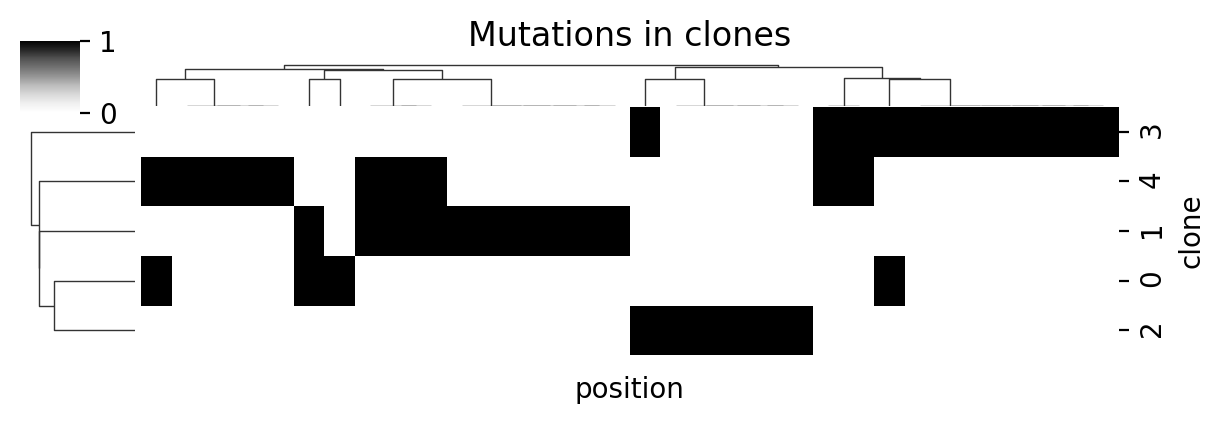

In [38]:
cg = sns.clustermap(
    clone_mutations.T, figsize=(6, 2), dendrogram_ratio=(0.1, 0.15), cmap="Greys"
)
cg.ax_heatmap.set_xlabel("position")
cg.ax_heatmap.set_ylabel("clone")
cg.ax_heatmap.set_xticklabels([])
cg.ax_heatmap.tick_params("x", size=0)
cg.ax_col_dendrogram.set_title("Mutations in clones")
plt.show()

The rate for the Poisson to randomly generate the number of total reads was set to achieve an average read count around 110 per spot.
This was the highest read coverage reported for the simulations in the manuscript.

In [39]:
np.random.seed(44)

# Randomly assign zygosity per position for each clone, allowing
# for copy number alterations.
zygosity = (
    np.random.choice([0.25, 0.5, 0.75, 1.0], size=(n_positions, N_CLONES))
    * clone_mutations
)

alt_read_counts = np.zeros((n_positions, N_SPOTS, N_CLONES))
tot_read_counts = np.zeros((n_positions, N_SPOTS, N_CLONES))

clone_cell_counts_per_spot = (
    cell_labels.groupby(["spot", "clone"])["cell"]
    .count()
    .reset_index()
    .rename(columns={"cell": "n_cells"})
)

for _, row in clone_cell_counts_per_spot.iterrows():
    clone_tot_reads = np.zeros(n_positions)
    clone_alt_reads = np.zeros(n_positions)
    for c in range(row["n_cells"]):
        cell_tot_reads = np.random.poisson(1.7, size=n_positions)
        cell_alt_reads = np.random.binomial(cell_tot_reads, zygosity[:, row["clone"]])
        clone_tot_reads = clone_tot_reads + cell_tot_reads
        clone_alt_reads = clone_alt_reads + cell_alt_reads
    tot_read_counts[:, row["spot"], row["clone"]] = clone_tot_reads
    alt_read_counts[:, row["spot"], row["clone"]] = clone_alt_reads

alt_read_counts = alt_read_counts.sum(axis=2)
tot_read_counts = tot_read_counts.sum(axis=2)

avg_read_cts = np.median(tot_read_counts.sum(axis=0))
print(f"average reads per spot: {round(avg_read_cts)}")

average reads per spot: 113


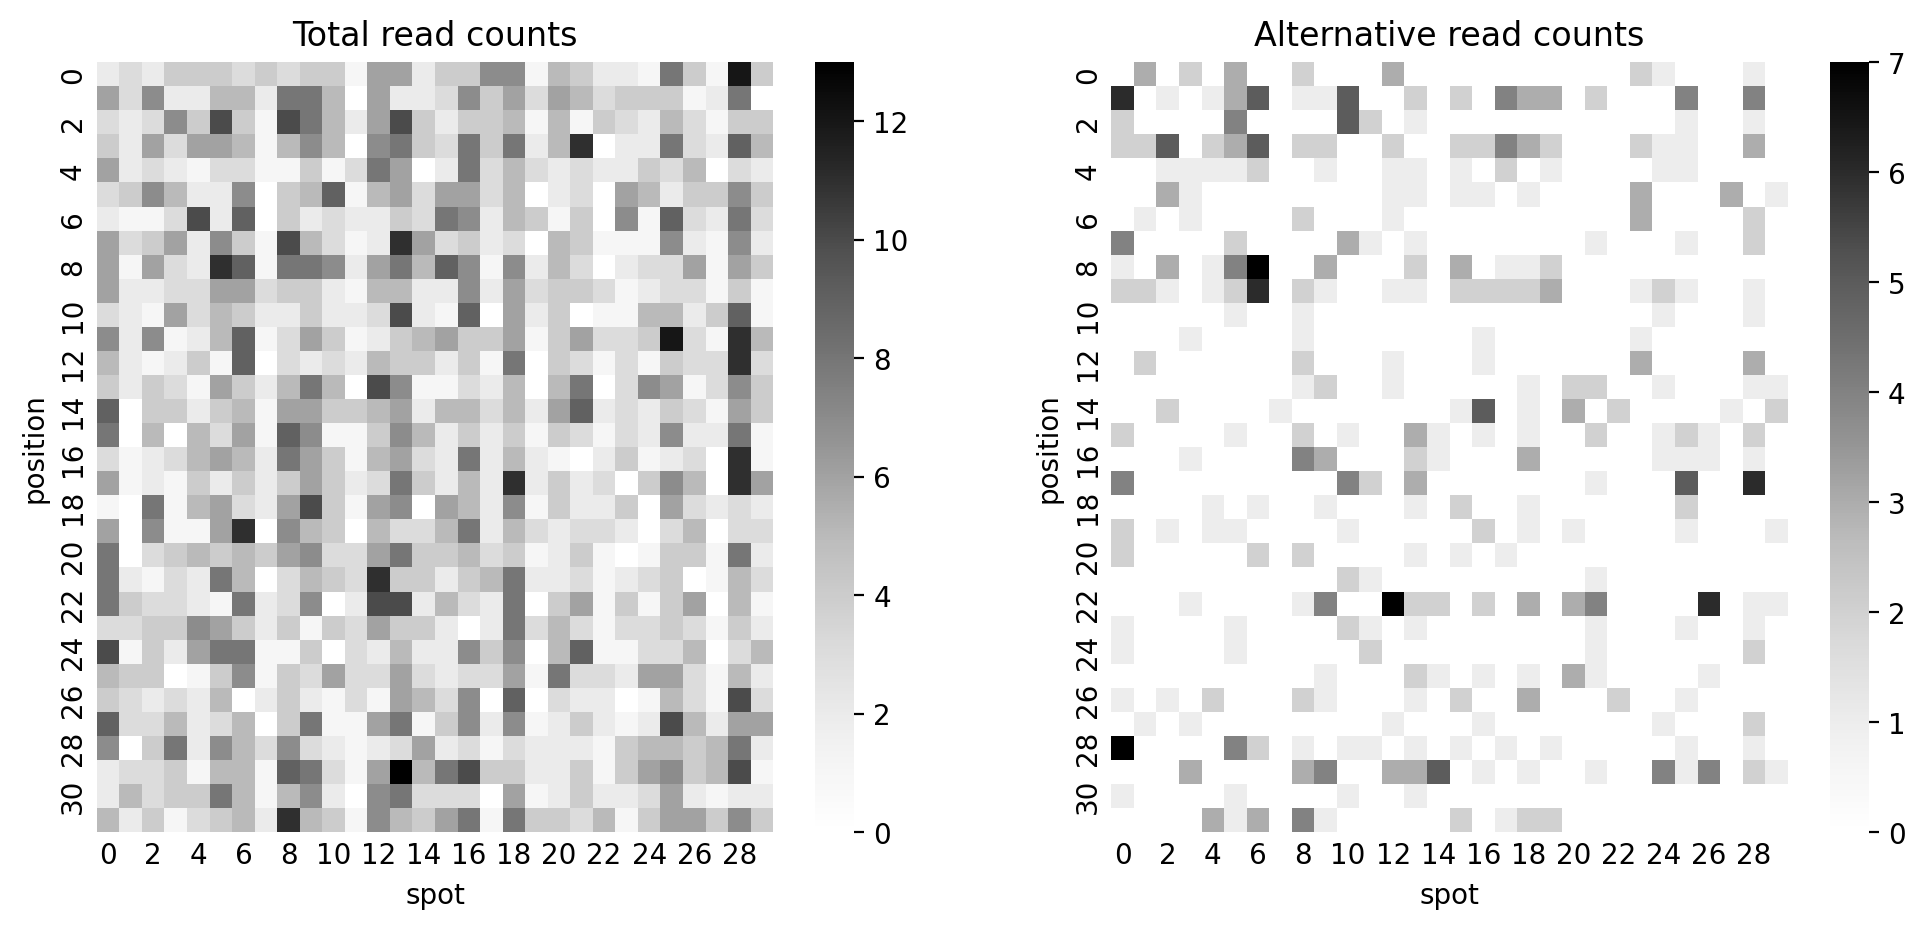

In [40]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 5))
sns.heatmap(tot_read_counts, cmap="Greys", ax=axes[0])
axes[0].set_title("Total read counts")
sns.heatmap(alt_read_counts, cmap="Greys", ax=axes[1])
axes[1].set_title("Alternative read counts")

for ax in axes:
    ax.tick_params(size=0)
    ax.set_xlabel("spot")
    ax.set_ylabel("position")

plt.show()

In [41]:
real_sim_data = TumoroscopeData(
    K=N_CLONES,
    S=N_SPOTS,
    M=n_positions,
    F_0=1,
    F=clone_proportions,
    cell_counts=cell_counts,
    C=zygosity,
    D_obs=tot_read_counts,
    A_obs=alt_read_counts,
    zeta_s=N_CLONES * 2,
    r=0.5,
    p=1,
)

realsim_trace_fp = models_dir / "realistic-simulation-trace.netcdf"
if False and realsim_trace_fp.exists():
    print("Removing trace cache.")
    os.remove(realsim_trace_fp)

if realsim_trace_fp.exists():
    print("Retrieving cached posterior.")
    realsim_trace = az.from_netcdf(realsim_trace_fp)
else:
    with tumoroscope(real_sim_data, fixed=False):
        realsim_trace = pm.sample(
            draws=1000, tune=1000, chains=4, cores=4, random_seed=10, target_accept=0.95
        )
        pm.sample_posterior_predictive(
            realsim_trace, random_seed=7348, extend_inferencedata=True
        )
    realsim_trace.to_netcdf(realsim_trace_fp)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [Π, G, Φ]
>BinaryGibbsMetropolis: [Z]
>Metropolis: [N]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 354 seconds.
/usr/local/Caskroom/miniconda/base/envs/pymc-tumoroscope/lib/python3.10/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/Caskroom/miniconda/base/envs/pymc-tumoroscope/lib/python3.10/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: divide by zero encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
Sampling: [A, D]


The posterior estimates for clone proportions are less accurate than before.
This is expected because there is far more uncertainty in this simulation.
The estimates do seem to trend with the true underlying values.

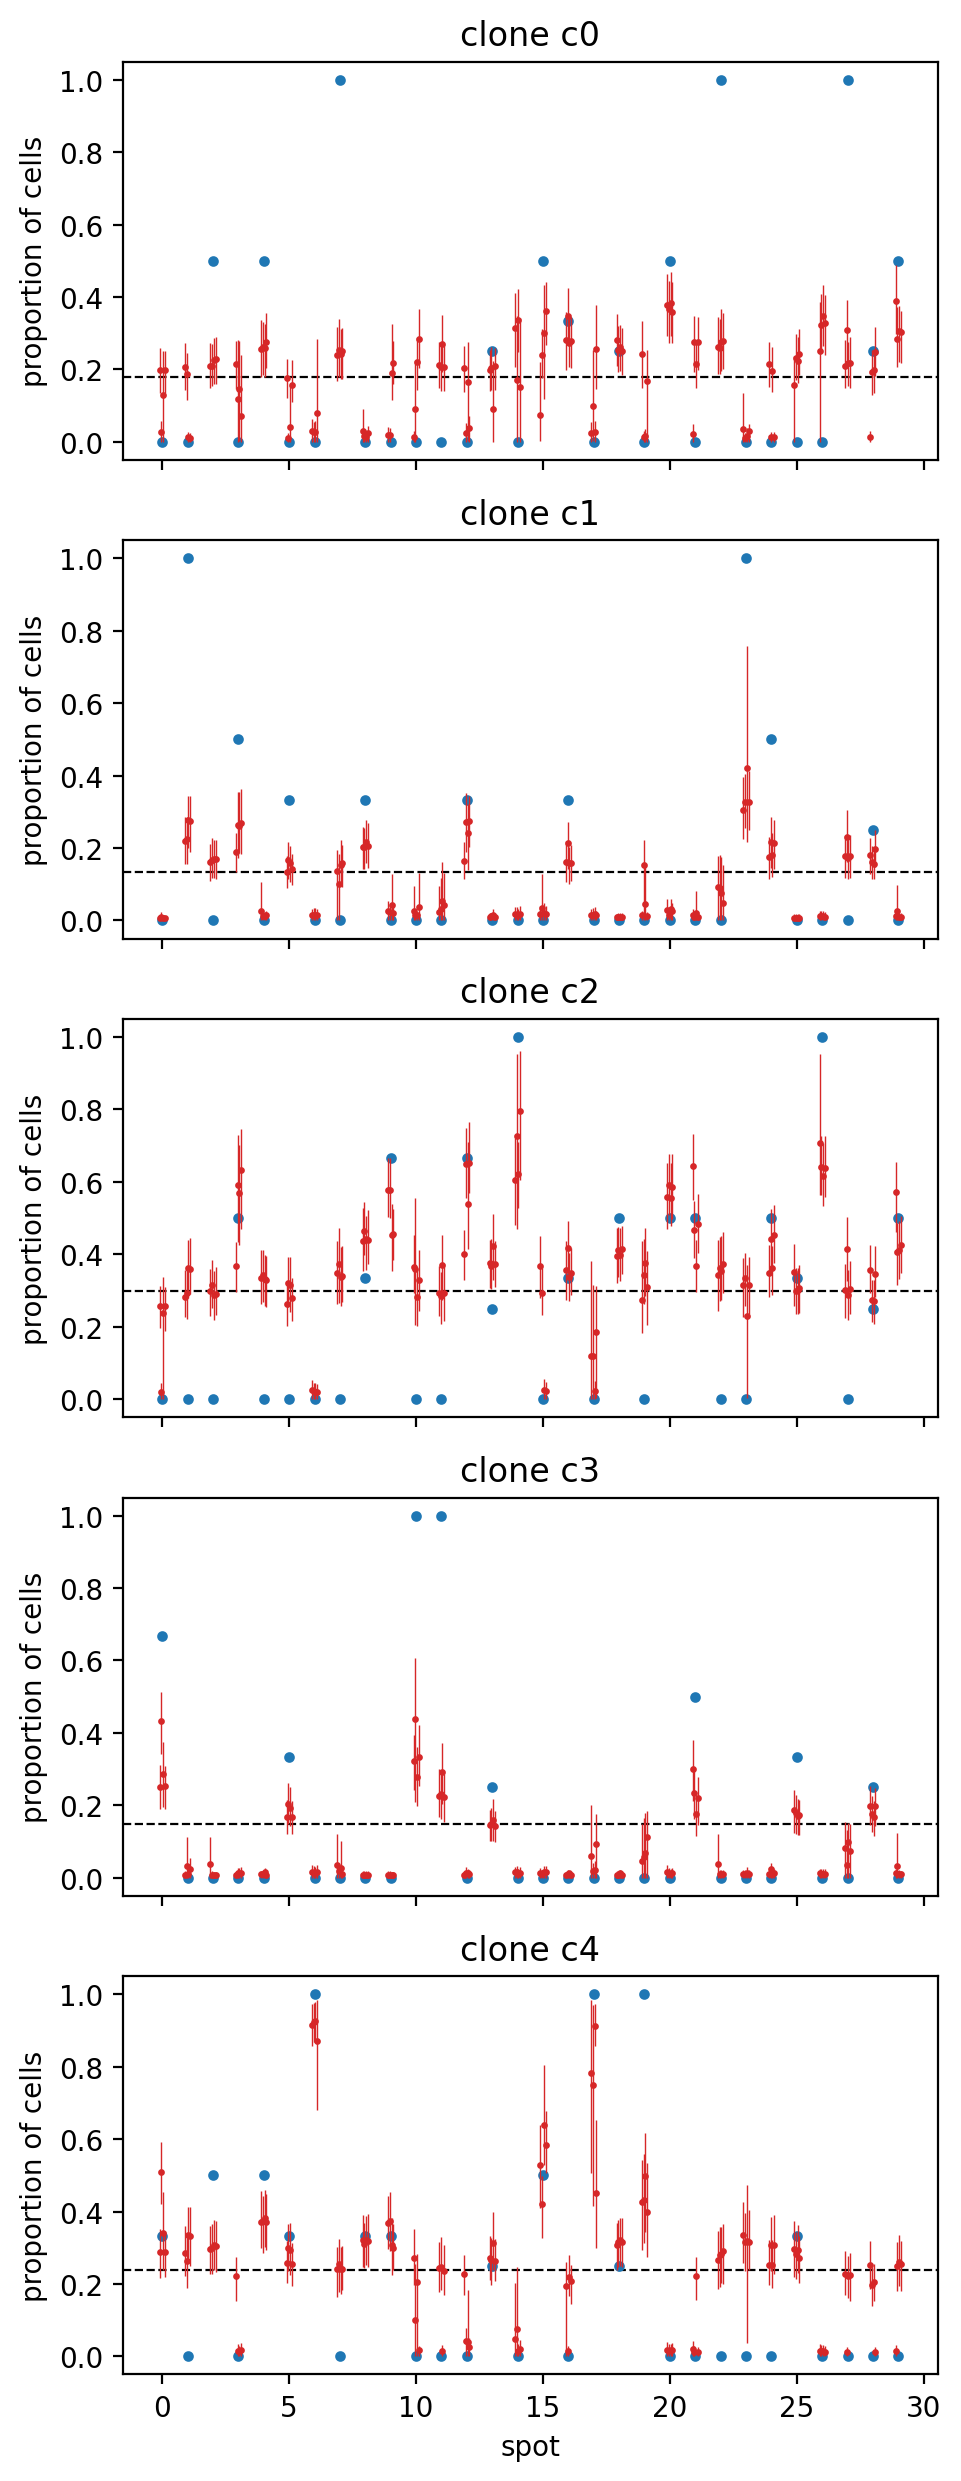

In [42]:
fig, axes = plt.subplots(
    nrows=real_sim_data.K, figsize=(5, 2.5 * real_sim_data.K), sharex=True
)
for clone_i, ax in enumerate(axes.flatten()):
    clone = f"c{clone_i}"
    ax.set_title(f"clone {clone}")

    # Plot true fraction of clones at each spot.
    true_clone_frac = cell_labels.groupby(["spot"])["clone"].apply(
        _frac_clone, k=clone_i
    )
    ax.scatter(
        true_clone_frac.index.tolist(),
        true_clone_frac.values.tolist(),
        c="tab:blue",
        s=8,
        zorder=10,
    )

    # Plot population fraction.
    ax.axhline(real_sim_data.F[clone_i], lw=0.8, c="k", ls="--")

    # Plot posterior.
    H = realsim_trace.posterior["H"].sel(clone=[clone])
    dx = np.linspace(-0.1, 0.1, len(H.coords["chain"]))
    spot = np.arange(real_sim_data.S)
    for chain in H.coords["chain"]:
        _x = spot + dx[chain]
        ax.scatter(_x, H.sel(chain=chain).mean(axis=(0)), c="tab:red", s=2, zorder=20)
        _hdi = az.hdi(H, coords={"chain": [chain]})["H"].values.squeeze()
        ax.vlines(
            x=_x, ymin=_hdi[:, 0], ymax=_hdi[:, 1], lw=0.5, zorder=10, color="tab:red"
        )
    ax.set_ylabel("proportion of cells")
    ax.set_xlabel(None)

axes[-1].set_xlabel("spot")
fig.tight_layout()
plt.show()

## Modified model

I propose a few changes to the implementation of the 'Tumoroscope' model:

1. Modeling the hyper-parameters for latent variables $\Phi$ and $\Pi$ as hierarchical distributions.
2. Use a Dirichlet distribution over $H$ as described in the Methods of the preprint:

$$
P(H_{s,1}, \dots, H_{s,K} | F^\prime, F_0, Z_{s, .}) \sim \text{Dirichlet}(F_1^{\prime Z_{s,1}} F_0^{1-Z_{s,1}}, \dots, F_K^{\prime Z_{s,K}} F_0^{1-Z_{s,K}})
$$

These changes are implemented in the `tumoroscope2()` function.

In [43]:
@dataclass
class Tumoroscope2Data:
    """Tumoroscope model data."""

    K: int  # number of clones
    S: int  # number of spots
    M: int  # number of mutation positions
    F: np.ndarray  # Prevelance of clones from bulk-DNA seq.
    cell_counts: np.ndarray  # Number of cell counted per spot
    C: np.ndarray  # Zygosity per position and clone
    D_obs: np.ndarray | None  # Read count per position per spot
    A_obs: np.ndarray | None  # Alternated reads per position per spot
    F_0: float = 1.0  # "pseudo-frequency" for lower bound on clone proportion
    l: float = 100  # Scaling factor to discretize F


def _check_tumoroscope2_data(data: Tumoroscope2Data) -> None:
    assert data.K > 0 and data.S > 0 and data.M > 0

    assert np.isclose(data.F.sum(), 1.0)
    assert data.F.ndim == 1
    assert data.F.shape[0] == data.K

    assert data.cell_counts.shape == (data.S,)
    assert np.all(data.cell_counts > 0)

    assert np.all(data.C >= 0.0) and np.all(data.C <= 1.0)
    assert data.C.shape == (data.M, data.K)

    if data.D_obs is not None:
        assert data.D_obs.shape == (data.M, data.S)

    if data.A_obs is not None:
        assert data.A_obs.shape == (data.M, data.S)

    assert data.F_0 > 0.0
    assert data.l > 0.0


def _make_tumoroscope2_model_coords(data: Tumoroscope2Data) -> dict[str, list[str]]:
    coords = {
        "clone": _prefixed_index(data.K, "c"),
        "spot": _prefixed_index(data.S, "s"),
        "position": _prefixed_index(data.M, "p"),
    }
    return coords


def tumoroscope2(data: Tumoroscope2Data, fixed: bool = False) -> pm.Model:
    _check_tumoroscope2_data(data)
    coords = _make_tumoroscope2_model_coords(data)
    with pm.Model(coords=coords) as model:
        ℓ = pm.ConstantData("ℓ", data.l)
        F_0 = pm.ConstantData("F0", data.F_0)
        F = pm.ConstantData("F", data.F, dims="clone")
        if not fixed:
            Λ = pm.ConstantData("Λ", data.cell_counts, dims="spot")
        C = pm.ConstantData("C", data.C, dims=("position", "clone"))

        F_prime = pm.Deterministic("F_prime", ℓ * at.ceil(20 * F) / 20, dims="clone")

        α = pm.Exponential("α", 1.5)
        β = pm.Exponential("β", 1.5)
        Π = pm.Beta("Π", alpha=α, beta=β, dims=("spot", "clone"))
        Z = pm.Bernoulli("Z", p=Π, dims=("spot", "clone"))
        # G = pm.Gamma(
        #     "G", (F_prime[None, :] ** Z) * (F_0 ** (1 - Z)), 1, dims=("spot", "clone")
        # )
        # H = pm.Deterministic("H", G / G.sum(axis=1)[:, None], dims=("spot", "clone"))
        H = pm.Dirichlet("H", (F_prime**Z) * (F_0 ** (1 - Z)), dims=("spot", "clone"))

        if fixed:
            N = pm.ConstantData("N", data.cell_counts, dims="spot")
        else:
            N = pm.Poisson("N", Λ, dims="spot")

        r = pm.Exponential("r", 2)
        Φ = pm.Gamma("Φ", r, 1, dims=("position", "clone"))

        D = pm.Poisson(
            "D", N * H.dot(Φ.T).T, dims=("position", "spot"), observed=data.D_obs
        )
        _A_num = H.dot((Φ * C).T).T
        _A_denom = H.dot(Φ.T).T
        A_prob = pm.Deterministic(
            "A_prob", _A_num / _A_denom, dims=("position", "spot")
        )
        A = pm.Binomial("A", D, A_prob, dims=("position", "spot"), observed=data.A_obs)
    return model

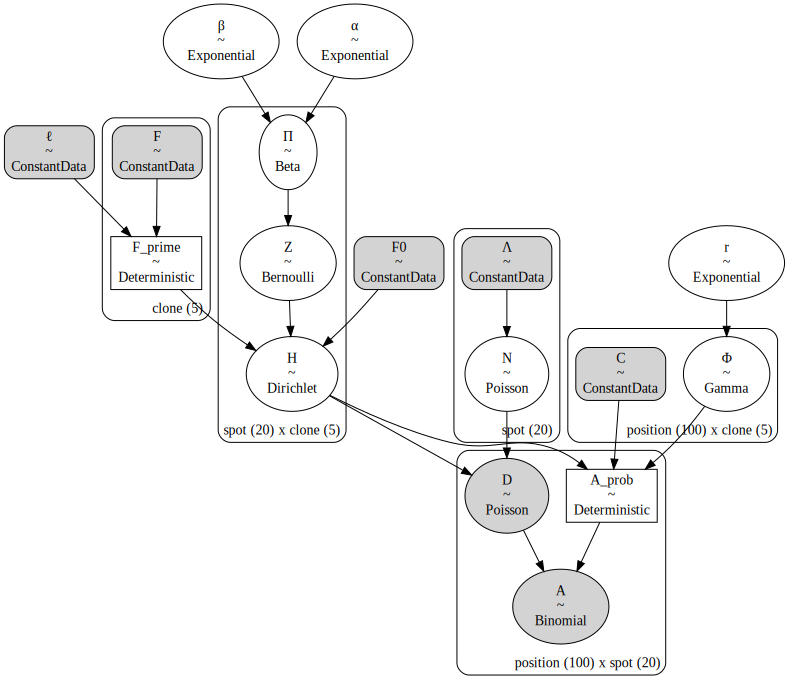

In [44]:
t2data = Tumoroscope2Data(
    K=5,
    S=20,
    M=100,
    F=np.ones(5) / 5.0,
    cell_counts=np.random.randint(2, 5, 20),
    C=np.random.uniform(0, 1, (100, 5)),
    D_obs=np.random.randint(1, 10, (100, 20)),
    A_obs=np.random.randint(1, 10, (100, 20)),
)

pm.model_to_graphviz(tumoroscope2(t2data))

Brief prior predictive sampling just to verify the model can be sampled from.

In [45]:
with tumoroscope2(t2data):
    _ = pm.sample_prior_predictive(random_seed=4)

Sampling: [A, D, H, N, Z, r, Π, Φ, α, β]


## Simulation experiments 2

### Simple simulation

Using the same simple, noise-free simulated data from before.

In [46]:
def convert_data_to_tumoroscope2_data(data: TumoroscopeData) -> Tumoroscope2Data:
    return Tumoroscope2Data(
        K=data.K,
        S=data.S,
        M=data.M,
        F=data.F,
        cell_counts=data.cell_counts,
        C=data.C,
        D_obs=data.D_obs,
        A_obs=data.A_obs,
        F_0=data.F_0,
        l=data.l,
    )

In [47]:
sim_t2_data = convert_data_to_tumoroscope2_data(sim_data)

sim_t2_trace_fp = models_dir / "simulation-t2_trace.netcdf"
if False and sim_t2_trace_fp.exists():
    print("Removing trace cache.")
    os.remove(sim_t2_trace_fp)

if sim_t2_trace_fp.exists():
    print("Retrieving cached posterior.")
    t2_sim_trace = az.from_netcdf(sim_t2_trace_fp)
else:
    with tumoroscope2(sim_t2_data, fixed=False):
        t2_sim_trace = pm.sample(
            draws=1000, tune=1000, chains=4, cores=4, random_seed=10, target_accept=0.9
        )
        pm.sample_posterior_predictive(
            t2_sim_trace, random_seed=7348, extend_inferencedata=True
        )
    t2_sim_trace.to_netcdf(sim_t2_trace_fp)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [α, β, Π, H, r, Φ]
>BinaryGibbsMetropolis: [Z]
>Metropolis: [N]


/usr/local/Caskroom/miniconda/base/envs/pymc-tumoroscope/lib/python3.10/site-packages/pymc/step_methods/metropolis.py:296: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/usr/local/Caskroom/miniconda/base/envs/pymc-tumoroscope/lib/python3.10/site-packages/pymc/step_methods/metropolis.py:296: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/usr/local/Caskroom/miniconda/base/envs/pymc-tumoroscope/lib/python3.10/site-packages/pymc/step_methods/metropolis.py:296: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/usr/local/Caskroom/miniconda/base/envs/pymc-tumoroscope/lib/python3.10/site-packages/pymc/step_methods/metropolis.py:296: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 213 seconds.
/usr/local/Caskroom

In [48]:
n_divs = t2_sim_trace.sample_stats.diverging.sum(axis=1).values
print(f"Number of divergences per chain: {n_divs}")

Number of divergences per chain: [0 0 0 0]


The marginal posterior distribution of $H$ appears to be tighter than in the original implementation.

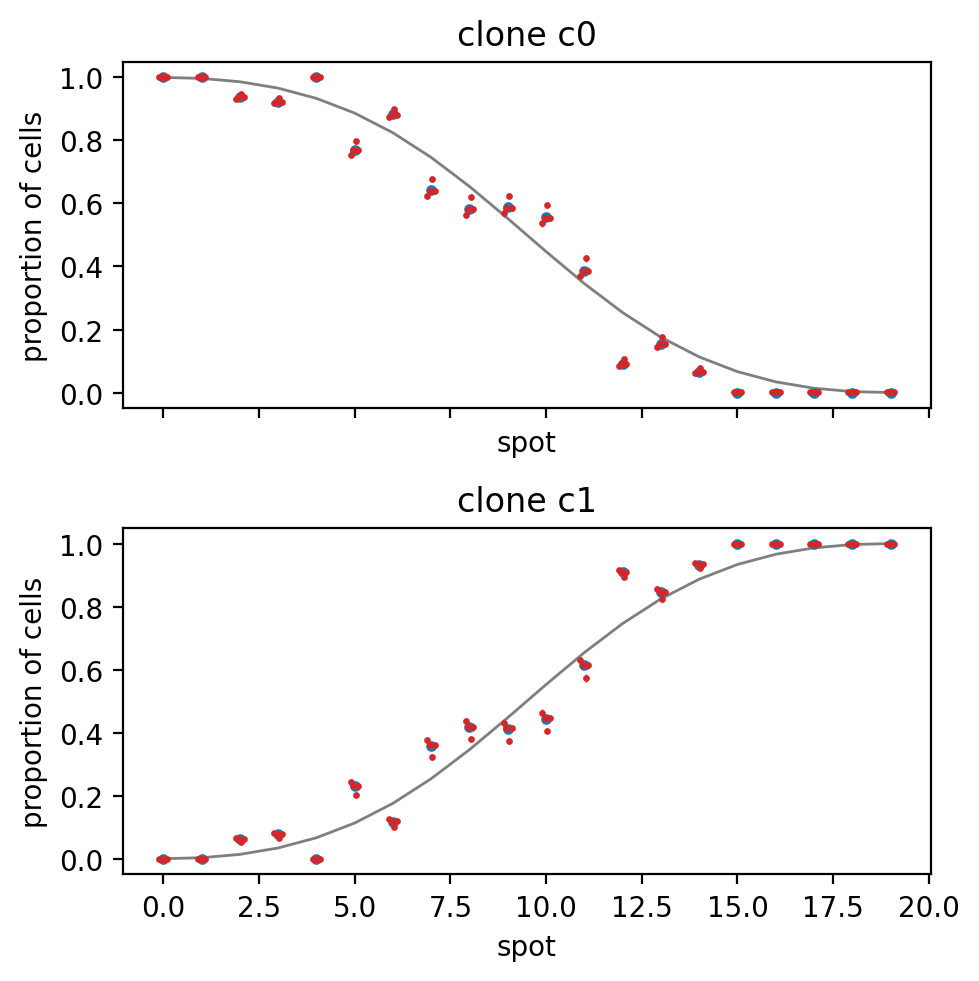

In [49]:
fig, axes = plt.subplots(
    nrows=sim_t2_data.K, figsize=(5, 2.5 * sim_t2_data.K), sharex=True
)
for clone_i, ax in enumerate(axes.flatten()):
    clone = f"c{clone_i}"
    ax.set_title(f"clone {clone}")

    # Plot true fraction of clones at each spot.
    true_clone_frac = (
        simple_sim_truth["cell_labels"]
        .groupby(["spot"])["clone"]
        .apply(_frac_clone, k=clone_i)
    )
    ax.scatter(
        true_clone_frac.index.tolist(),
        true_clone_frac.values.tolist(),
        c="tab:blue",
        s=8,
        zorder=10,
    )

    # Plot true underlying proportion of clones at each spot.
    spot = np.arange(sim_t2_data.S)
    ax.plot(
        spot,
        simple_sim_truth["clone_proportions"][:, clone_i],
        c="tab:grey",
        lw=1,
        zorder=5,
    )

    # Plot posterior.
    H = t2_sim_trace.posterior["H"].sel(clone=[clone])
    dx = np.linspace(-0.1, 0.1, len(H.coords["chain"]))
    for chain in H.coords["chain"]:
        _x = spot + dx[chain]
        ax.scatter(_x, H.sel(chain=chain).mean(axis=(0)), c="tab:red", s=2, zorder=20)
        _hdi = az.hdi(H, coords={"chain": [chain]})["H"].values.squeeze()
        ax.vlines(
            x=_x, ymin=_hdi[:, 0], ymax=_hdi[:, 1], lw=0.5, zorder=10, color="tab:red"
        )
    ax.set_xlabel("spot")
    ax.set_ylabel("proportion of cells")

fig.tight_layout()
plt.show()

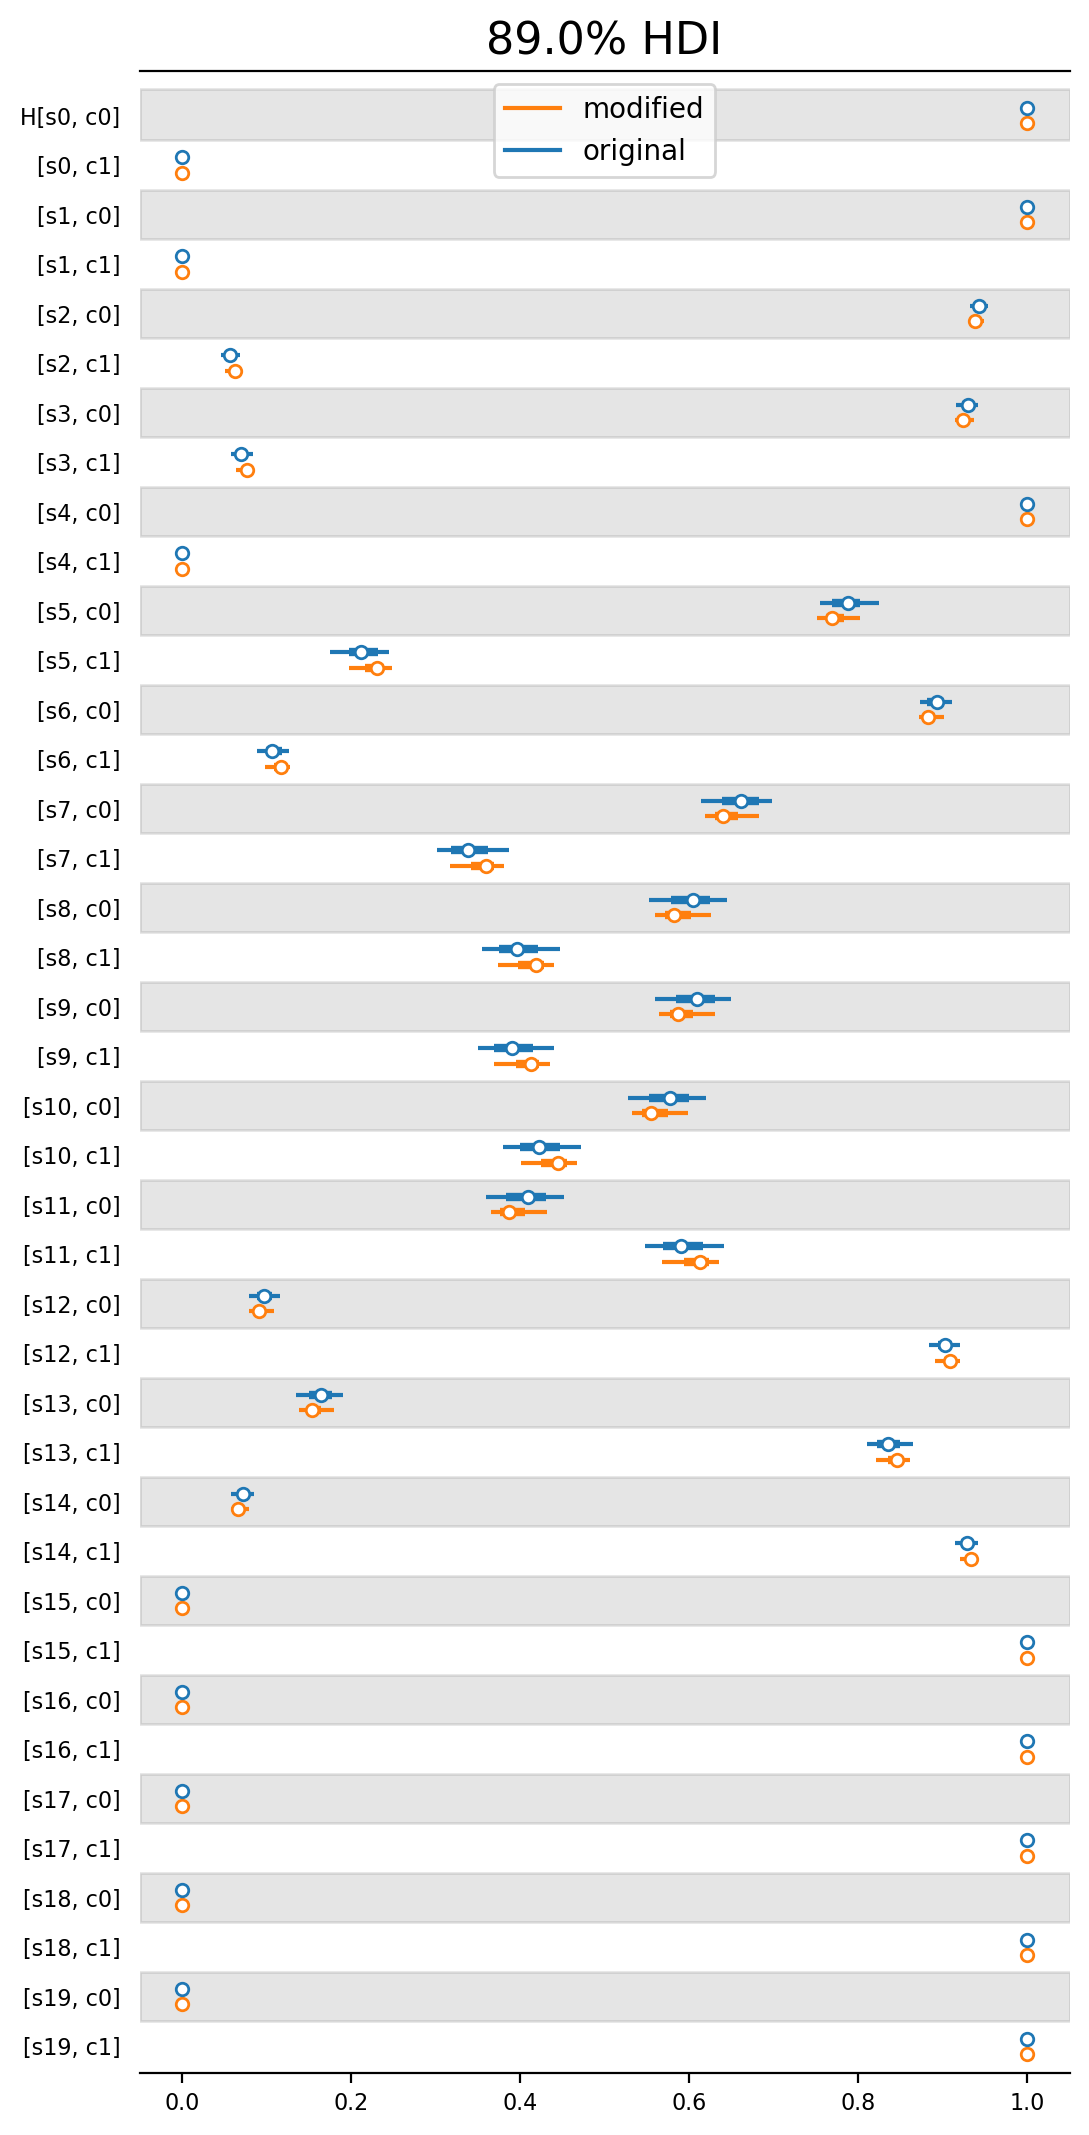

In [50]:
ax = az.plot_forest(
    [sim_trace, t2_sim_trace],
    model_names=["original", "modified"],
    var_names=["H"],
    combined=True,
)
ax[0].tick_params(labelsize=8)
plt.show()

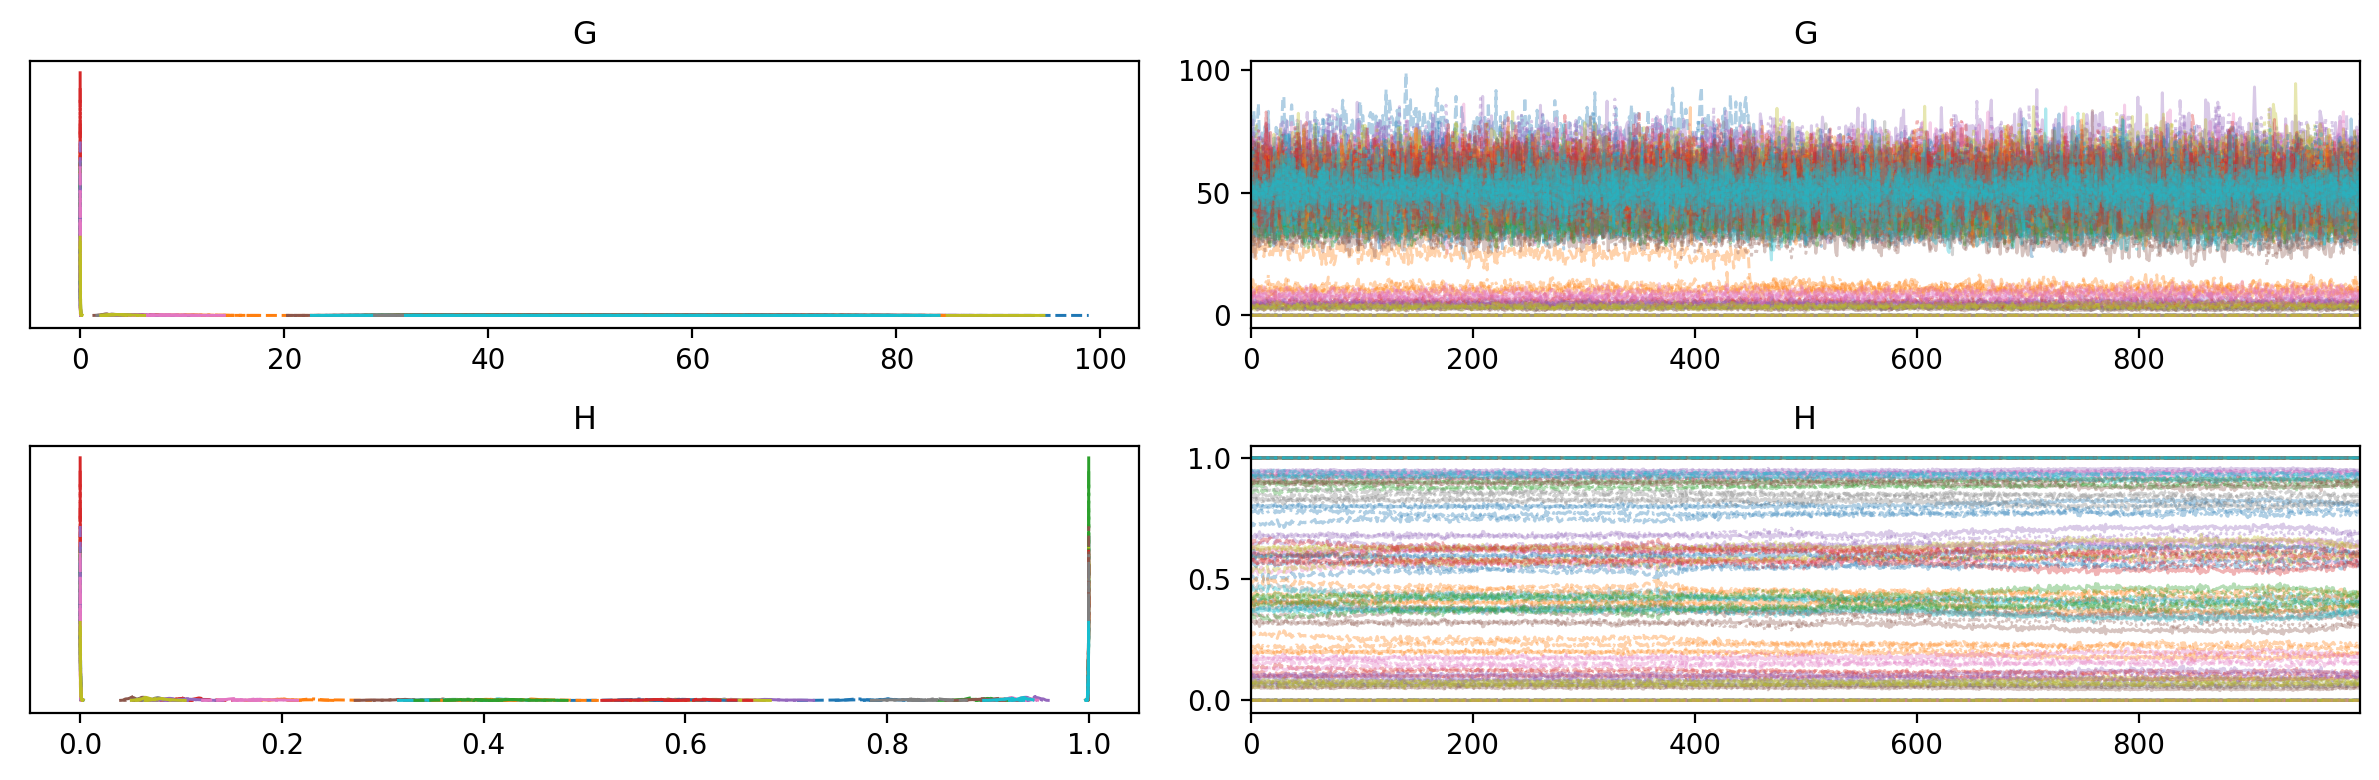

In [51]:
az.plot_trace(sim_trace, var_names=["G", "H"])
plt.tight_layout()

### Realistic simulation

Again, fitting the second 'Tumoroscope' implementation with the same simulation data to compare results.

In [52]:
real_sim_t2_data = convert_data_to_tumoroscope2_data(real_sim_data)

realsim_t2_trace_fp = models_dir / "realistic-simulation-t2-trace.netcdf"
if False and realsim_t2_trace_fp.exists():
    print("Removing trace cache.")
    os.remove(realsim_t2_trace_fp)

if realsim_t2_trace_fp.exists():
    print("Retrieving cached posterior.")
    t2_realsim_trace = az.from_netcdf(realsim_t2_trace_fp)
else:
    with tumoroscope2(real_sim_t2_data):
        t2_realsim_trace = pm.sample(
            draws=1000, tune=1000, chains=4, cores=4, random_seed=10, target_accept=0.95
        )
        pm.sample_posterior_predictive(
            t2_realsim_trace, random_seed=7348, extend_inferencedata=True
        )
    t2_realsim_trace.to_netcdf(realsim_t2_trace_fp)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [α, β, Π, H, r, Φ]
>BinaryGibbsMetropolis: [Z]
>Metropolis: [N]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 591 seconds.
/usr/local/Caskroom/miniconda/base/envs/pymc-tumoroscope/lib/python3.10/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/Caskroom/miniconda/base/envs/pymc-tumoroscope/lib/python3.10/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: divide by zero encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
Sampling: [A, D]


In [53]:
n_divs = t2_realsim_trace.sample_stats.diverging.sum(axis=1).values
print(f"Number of divergences per chain: {n_divs}")

Number of divergences per chain: [0 0 0 0]


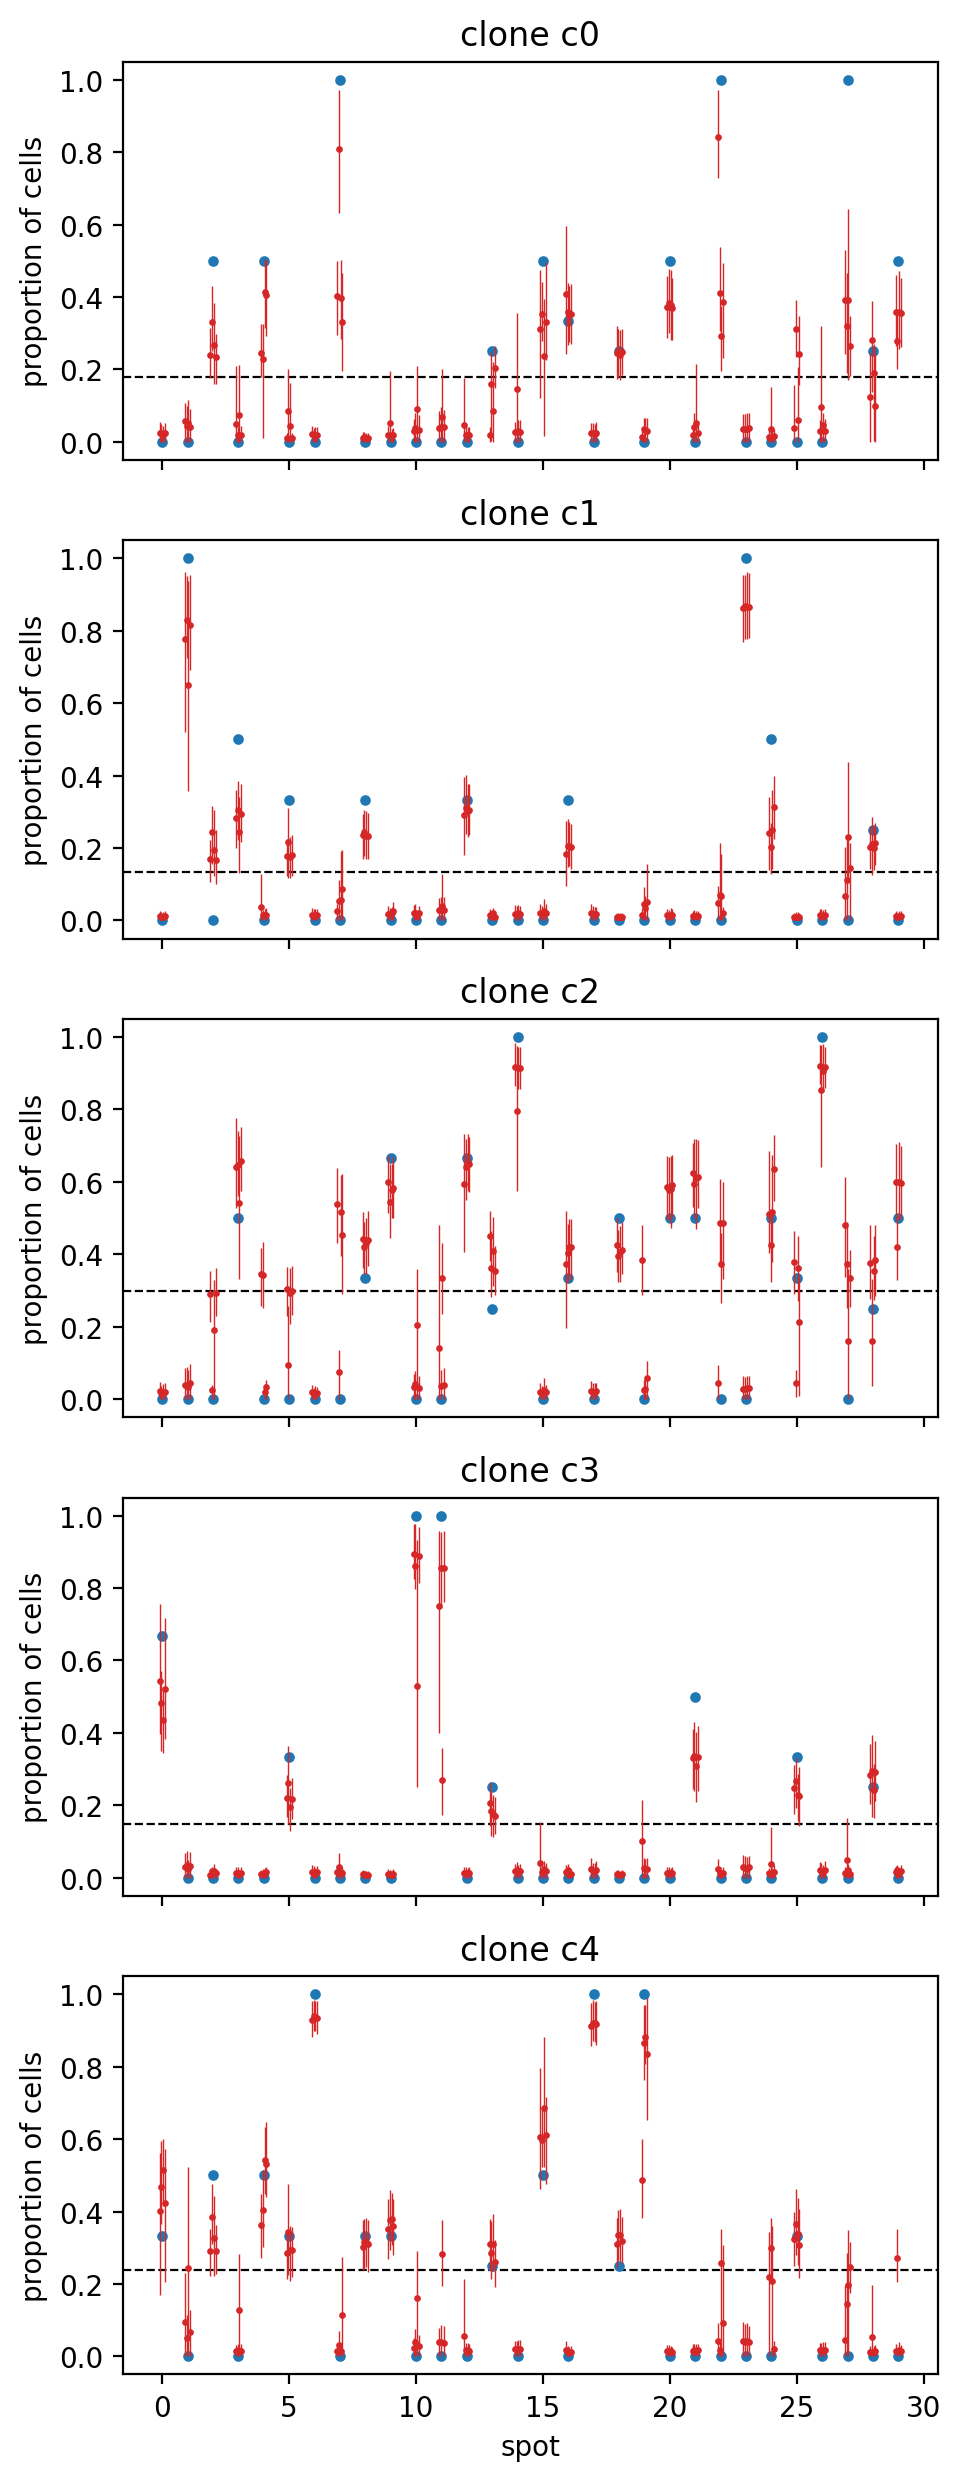

In [54]:
fig, axes = plt.subplots(
    nrows=real_sim_t2_data.K, figsize=(5, 2.5 * real_sim_t2_data.K), sharex=True
)
for clone_i, ax in enumerate(axes.flatten()):
    clone = f"c{clone_i}"
    ax.set_title(f"clone {clone}")

    # Plot true fraction of clones at each spot.
    true_clone_frac = (
        real_sim_truth["cell_labels"]
        .groupby(["spot"])["clone"]
        .apply(_frac_clone, k=clone_i)
    )
    ax.scatter(
        true_clone_frac.index.tolist(),
        true_clone_frac.values.tolist(),
        c="tab:blue",
        s=8,
        zorder=10,
    )

    # Plot population fraction.
    ax.axhline(real_sim_t2_data.F[clone_i], lw=0.8, c="k", ls="--")

    # Plot posterior.
    H = t2_realsim_trace.posterior["H"].sel(clone=[clone])
    dx = np.linspace(-0.1, 0.1, len(H.coords["chain"]))
    spot = np.arange(real_sim_data.S)
    for chain in H.coords["chain"]:
        _x = spot + dx[chain]
        ax.scatter(_x, H.sel(chain=chain).mean(axis=(0)), c="tab:red", s=2, zorder=20)
        _hdi = az.hdi(H, coords={"chain": [chain]})["H"].values.squeeze()
        ax.vlines(
            x=_x, ymin=_hdi[:, 0], ymax=_hdi[:, 1], lw=0.5, zorder=10, color="tab:red"
        )
    ax.set_ylabel("proportion of cells")
    ax.set_xlabel(None)

axes[-1].set_xlabel("spot")
fig.tight_layout()
plt.show()

## Final thoughts

The 'Tumoroscope' is an interesting model. 
It took awhile for me to truly understand how it worked, but eventually I was able to realize that it is really a fairly simple, straightforward model.
I added a few simple improvements that seemed to help the model fit to the simulated data.
I believe these were not included in the current version described in the pre-print because they make constructing the Gibbs Sampler equations more difficult.
Using PyMC, I was able to successfully implement the modifications with no difficulties.
Another improvement that I think could be added would be to include spatial relationships between spots to share information.

---

## Session information

In [55]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2022-10-15

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.5.0

Compiler    : Clang 13.0.1 
OS          : Darwin
Release     : 21.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

Hostname: JHCookMac.local

Git branch: tumoroscope-2

janitor   : 0.22.0
arviz     : 0.12.1
seaborn   : 0.12.0
matplotlib: 3.6.0
aesara    : 2.8.6
pymc      : 4.2.1
numpy     : 1.23.3
scipy     : 1.9.1
pandas    : 1.5.0

